<h1>Desafio 1 - Grupo 5</h1>

<h3><u>Intregrantes del grupo</u></h3>

- Lesertesseur, Diego
- Panizza, Camila  
- Pellecchia, Franco   
- Magariños, Néstor  
- Suarez, Horacio  

<h3><u>Objetivos</u></h3>
La inmobiliaria Properati publica periódicamente información sobre ofertas de propiedades
para venta y alquiler. Ud. deberá asesorar a la inmobiliaria a desarrollar un modelo de
regresión que permita predecir el precio por metro cuadrado de una propiedad. El objetivo
final es que el modelo que desarrollen sea utilizado como tasador automático a ser
aplicados a las próximas propiedades que sean comercializadas por la empresa. Para ello
la empresa le provee de un dataset correspondiente al primer semestre de 2017.

- Efectuar una limpieza del dataset provisto. Particularmente, deberá diseñar estrategias para lidiar con los datos perdidos en ciertas variables.
- Realizar un análisis descriptivo de las principales variables.
- Crear nuevas columnas a partir de las características dadas que puedan tener valor
predictivo.

<h3><u>Variables</u></h3>

- Fecha de creación
- Tipo de la propiedad (house, apartment, ph)
- Operación del aviso (sell, rent)
- Nombre del lugar
- Nombre del lugar + nombre de sus ‘padres’
- ID de geonames del lugar (si está disponible)
- Latitud,Longitud
- Precio original del aviso
- Moneda original del aviso (ARS, USD)
- Precio del aviso en moneda local (ARS)
- Precio aproximado en USD
- Superficie en m²
- Superficie cubierta en m²
- Precio en USD/m²
- Precio por m²
- N° de piso, si corresponde
- Ambientes
- URL en Properati
- Descripción
- Título
- URL de un thumbnail de la

<h3><u>Índice</u></h3>
<a href='#section_1'>1. Preparación del dataset</a> 

<a href='#section_2'>2. Data wrangling</a>  
<a href='#section_3'>3. Nuevas variables</a>  
<a href='#section_4'>4. Dataset final</a>    
<a href='#section_5'>5. Construcción del modelo</a>

---
---
<b><a id='section_1'><h4>1. Preparación del dataset</h4></a></b>
<a href='#section_1_1'>1.1. Importación de librerías y carga del dataset</a>  
<a href='#section_1_2'>1.2. Descripción del dataset</a>  
<a href='#section_1_3'>1.3. Selección de columnas útiles</a>  
<a href='#section_1_4'>1.4. Detección de duplicados</a>

<b><a id='section_1_1'>1.1. Importación de librerías y carga del dataset</a>  </b>

In [250]:
import numpy as np
import pandas as pd
import re 
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
%matplotlib inline

In [251]:
data= pd.read_csv("../../data/properati.csv")

---
<b><a id='section_1_2'>1.2. Descripción del dataset</a></b>

In [252]:
data_describe = pd.DataFrame(round(data.isnull().sum() /data.shape[0],2), columns= ['Porcentaje de nulos'])
data_describe['type'] = data.dtypes
data_describe = data_describe[['type','Porcentaje de nulos']]
data_describe['Nulos'] = data.isnull().sum()
values= []
example=[]
for x in data:
    values.append(len(data[x].unique()))
    example.append(data[x].unique())
data_describe['Valores distintos'] = values
data_describe['Ejemplos'] = example

data_describe

,type,Porcentaje de nulos,Nulos,Valores distintos,Ejemplos
Unnamed: 0,int64,0.00,0,121220,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
operation,object,0.00,0,1,[sell]
property_type,object,0.00,0,4,"[PH, apartment, house, store]"
place_name,object,0.00,23,1061,"[Mataderos, La Plata, Liniers, Centro, Gualegu..."
place_with_parent_names,object,0.00,0,1164,"[|Argentina|Capital Federal|Mataderos|, |Argen..."
country_name,object,0.00,0,1,[Argentina]
state_name,object,0.00,0,28,"[Capital Federal, Bs.As. G.B.A. Zona Sur, Buen..."
geonames_id,float64,0.15,18717,647,"[3430787.0, 3432039.0, 3431333.0, 3435548.0, 3..."
lat-lon,object,0.43,51550,47204,"[-34.6618237,-58.5088387, -34.9038831,-57.9643..."
lat,float64,0.43,51550,46496,"[-34.6618237, -34.9038831, -34.6522615, -34.64..."


---
<b><a id='section_1_3'>1.3. Selección de columnas útiles</a></b>

In [253]:
columnasUtiles=   ['property_type','place_name','state_name', 'place_with_parent_names', 'price', 'currency','price_aprox_local_currency',
                   'price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','price_usd_per_m2',
                   'rooms', 'expenses','description','title']
data_describe_utiles = data_describe.loc[columnasUtiles,:]
data_describe_utiles

,type,Porcentaje de nulos,Nulos,Valores distintos,Ejemplos
property_type,object,0.00,0,4,"[PH, apartment, house, store]"
place_name,object,0.00,23,1061,"[Mataderos, La Plata, Liniers, Centro, Gualegu..."
state_name,object,0.00,0,28,"[Capital Federal, Bs.As. G.B.A. Zona Sur, Buen..."
place_with_parent_names,object,0.00,0,1164,"[|Argentina|Capital Federal|Mataderos|, |Argen..."
price,float64,0.17,20410,9747,"[62000.0, 150000.0, 72000.0, 95000.0, 64000.0,..."
currency,object,0.17,20411,5,"[USD, nan, ARS, PEN, UYU]"
price_aprox_local_currency,float64,0.17,20410,10365,"[1093959.0, 2646675.0, 1270404.0, 1676227.5, 1..."
price_aprox_usd,float64,0.17,20410,10365,"[62000.0, 150000.0, 72000.0, 95000.0, 64000.0,..."
surface_total_in_m2,float64,0.32,39328,1688,"[55.0, nan, 35.0, 53.0, 106.0, 45.0, 65.0, 151..."
surface_covered_in_m2,float64,0.16,19907,996,"[40.0, nan, 55.0, 35.0, 78.0, 60.0, 36.0, 30.0..."


---
<b><a id='section_1_4'>1.4. Deteción de duplicados</a></b>  
Se procede a eliminar las observaciones duplicadas según las variables indicadas en 'columnasDuplicadas'. Se opta por conservar las observaciones que tienen descripción más larga

In [254]:
columnasDuplicadas = ['property_type','place_name','state_name', 'place_with_parent_names',
                      'surface_total_in_m2','surface_covered_in_m2','title']
data[columnasDuplicadas].duplicated().sum()

19066

In [255]:
data['description_len'] = data['description'].apply(lambda x: len(str(x)))
data = data.sort_values(by=['description_len'], ascending= False)

In [256]:
display(data.shape)
data = data.drop_duplicates(subset = columnasDuplicadas, keep= 'first')
display(data.shape)

(121220, 27)

(102154, 27)

In [257]:
data = data.reset_index()

---
---

<b><a id='section_2'><h4>2. Data wrangling</h4></a></b>
<a href='#section_2_1'>2.1. Columna 'property_type'</a>  
<a href='#section_2_2'>2.2. Columnas 'country_name', 'state_name', 'place_name' y'place_with_parent_names'</a>  
<a href='#section_2_3'>2.3. Columnas 'price','currency','price_aprox_local_currency' y 'price_aprox_usd' </a>  
<a href='#section_2_4'>2.4. Columna 'rooms'</a>  
<a href='#section_2_5'>2.5. Columna 'floor'</a>  
<a href='#section_2_6'>2.6. Columnas 'surface_total_in_m2' y 'surface_covered_in_m2'</a>  
<a href='#section_2_7'>2.7. Columna 'price_usd_per_m2'</a>  

In [258]:
data['description_lower'] = data['description'].str.lower()
data['title_lower'] = data['title'].str.lower()

---
<b><a id='section_2_1'>2.1. Columna 'property_type'</a></b>

Análisis de valores y nulos

In [259]:
data_describe.loc[data_describe.index.isin(['property_type']),:]

,type,Porcentaje de nulos,Nulos,Valores distintos,Ejemplos
property_type,object,0.0,0,4,"[PH, apartment, house, store]"


Visualización

,property_type
apartment,54.0
house,37.0
PH,5.2
store,3.9


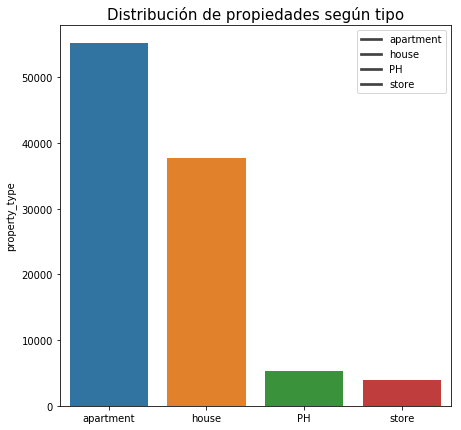

In [260]:
f, ax = plt.subplots()
f.set_figwidth(7)
f.set_figheight(7)
sns.barplot(y=data['property_type'].value_counts(),x=data['property_type'].value_counts().index)
plt.title("Distribución de propiedades según tipo",fontsize=15)
plt.legend(labels=data['property_type'].value_counts().index)
pd.DataFrame(round((data['property_type'].value_counts()/data.shape[0])*100,1))

---
<b><a id='section_2_2'>2.2. Columnas 'country_name', 'state_name', 'place_name' y'place_with_parent_names'</a></b>

Análisis de valores y nulos

In [261]:
data_describe.loc[data_describe.index.isin(['country_name', 'state_name', 'place_name','place_with_parent_names']),:]

,type,Porcentaje de nulos,Nulos,Valores distintos,Ejemplos
place_name,object,0.0,23,1061,"[Mataderos, La Plata, Liniers, Centro, Gualegu..."
place_with_parent_names,object,0.0,0,1164,"[|Argentina|Capital Federal|Mataderos|, |Argen..."
country_name,object,0.0,0,1,[Argentina]
state_name,object,0.0,0,28,"[Capital Federal, Bs.As. G.B.A. Zona Sur, Buen..."


Dividimos la columna 'place_with_parent_names' y analizamos su contenido.

In [262]:
data['place_with_parent_names_clean'] = data['place_with_parent_names']

total_place = data['place_with_parent_names_clean'].apply(lambda row: len(row.split('|'))-2)
dic_ret = dict()
for i in range(total_place.max()):
    dic_ret['place_'+ str(i)] = ([None] * total_place.shape[0])

In [263]:
for row in data['place_with_parent_names_clean'].index:
    i=0;
    list_places = data['place_with_parent_names_clean'].loc[row].split('|')
    for x in list_places:
        if len(x)>0:
            colname='place_' + str(i)
            dic_ret[colname][row] = x
            i+=1

In [264]:
new_columns = pd.DataFrame(dic_ret)
data = data.join(new_columns)

In [265]:
data[['country_name','state_name','place_name','place_0','place_1','place_2','place_3','place_4']].sample(10)

,country_name,state_name,place_name,place_0,place_1,place_2,place_3,place_4
98697,Argentina,Bs.As. G.B.A. Zona Sur,Lomas de Zamora,Argentina,Bs.As. G.B.A. Zona Sur,Lomas de Zamora,Lomas de Zamora,None
101308,Argentina,Córdoba,Córdoba,Argentina,Córdoba,Córdoba,None,None
79082,Argentina,Bs.As. G.B.A. Zona Sur,Manuel B Gonnet,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,Manuel B Gonnet,None
27765,Argentina,Santa Fe,Rosario,Argentina,Santa Fe,Rosario,None,None
95329,Argentina,Capital Federal,Mataderos,Argentina,Capital Federal,Mataderos,None,None
61062,Argentina,Bs.As. G.B.A. Zona Oeste,Ituzaingó,Argentina,Bs.As. G.B.A. Zona Oeste,Ituzaingó,None,None
50479,Argentina,Capital Federal,Balvanera,Argentina,Capital Federal,Balvanera,None,None
59217,Argentina,Bs.As. G.B.A. Zona Norte,Nordelta,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,Nordelta,None
454,Argentina,Bs.As. G.B.A. Zona Norte,Estancias del Pilar,Argentina,Bs.As. G.B.A. Zona Norte,Pilar,Estancias del Pilar,None
6251,Argentina,Bs.As. G.B.A. Zona Norte,Nordelta,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,Nordelta,None


La columna place_with_parent_names contiene la misma información que las columnas 'country_name', 'state_name' y 'place_name' e incluye información adicional.  
Se opta por utilizar la información proveniente de 'place_with_parent_name' y <u>se generan las variables 'provincia','ciudad','departamento' y'barrio'</u>

In [266]:
data[['provincia','ciudad','departamento','barrio']] = data[['place_1','place_2','place_3','place_4']]

Visualización

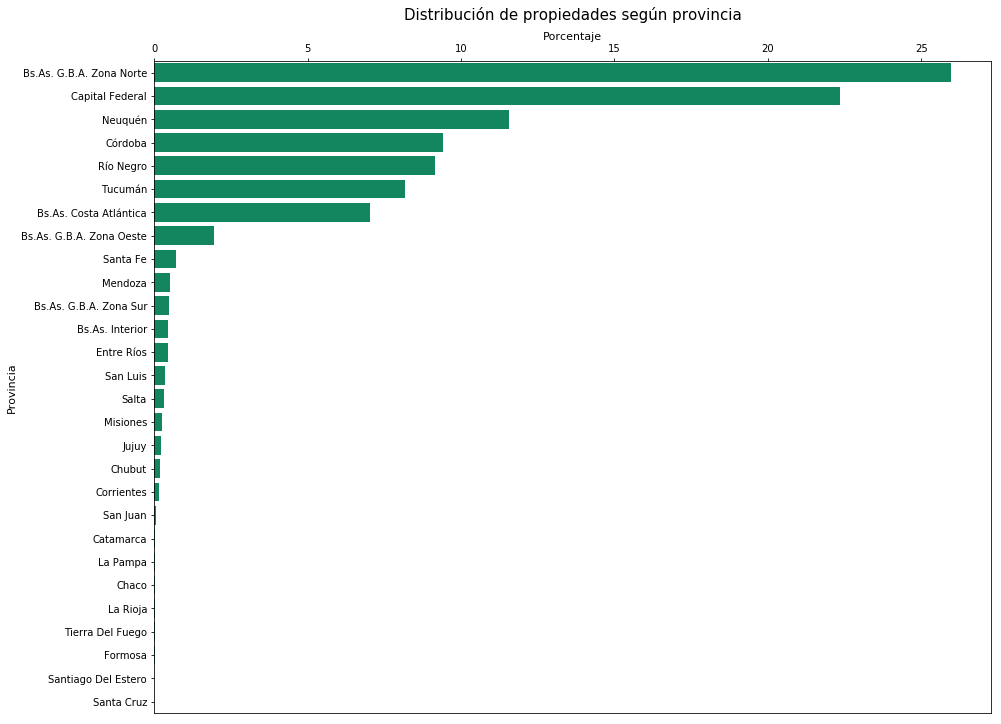

In [267]:
patternBsAs = re.compile("Buenos Aires\s*")
data['provincia'] = data['provincia'].apply(lambda x: patternBsAs.sub('Bs.As. ', x))

f, ax = plt.subplots()
f.set_figwidth(15)
f.set_figheight(12)
sns.barplot((data['provincia'].value_counts()/data['provincia'].shape[0])*100,data['provincia'].unique(), ax=ax , color = "#009966", orient="h")
plt.title("Distribución de propiedades según provincia\n\n",fontsize=15)
plt.xlabel("Porcentaje",fontsize=11)
ax.xaxis.set_label_position('top') 
plt.ylabel("Provincia",fontsize=11)
ax.xaxis.tick_top()

---
<b><a id='section_2_3'>2.3. Columnas 'price','currency','price_aprox_local_currency' y 'price_aprox_usd' </a>  </b>

Análisis de valores y nulos

In [268]:
data_describe.loc[data_describe.index.isin(['price','currency','price_aprox_local_currency','price_aprox_usd']),:]

,type,Porcentaje de nulos,Nulos,Valores distintos,Ejemplos
price,float64,0.17,20410,9747,"[62000.0, 150000.0, 72000.0, 95000.0, 64000.0,..."
currency,object,0.17,20411,5,"[USD, nan, ARS, PEN, UYU]"
price_aprox_local_currency,float64,0.17,20410,10365,"[1093959.0, 2646675.0, 1270404.0, 1676227.5, 1..."
price_aprox_usd,float64,0.17,20410,10365,"[62000.0, 150000.0, 72000.0, 95000.0, 64000.0,..."


In [269]:
maskNull_priceAndCurrency = data['price'].isnull() & data['currency'].isnull() &\
                            data['price_aprox_local_currency'].isnull() &\
                            data['price_aprox_usd'].isnull()

print("Cantidad de nulos que coinciden:",maskNull_priceAndCurrency.value_counts()[True],"de 20411")

Cantidad de nulos que coinciden: 15296 de 20411


In [270]:
data.loc[data['currency'].isnull() & data['price'].notnull() ,['price','currency','price_aprox_local_currency','price_aprox_usd']]

,price,currency,price_aprox_local_currency,price_aprox_usd
101219,0.0,NaN,0.0,0.0


Detectamos que <u>los nulos de las columnas  'price','currency','price_aprox_local_currency' y 'price_aprox_usd' coinciden</u>  
Existe un solo nulo adicional en la columna 'currency' en el cual el resto toma valor 0. Se decide reemplazar esos 0 por NaN

In [271]:
data[['price_clean', 'price_aprox_local_currency_clean','price_aprox_usd_clean']]=data[['price','price_aprox_local_currency','price_aprox_usd']]

In [272]:
data.loc[data['currency'].isnull(),['price_clean', 'price_aprox_local_currency_clean','price_aprox_usd_clean']] = np.NaN
data.loc[9761,['price_clean', 'currency', 'price_aprox_local_currency_clean','price_aprox_usd_clean']]

price_clean                              185000
currency                                    USD
price_aprox_local_currency_clean    3.26423e+06
price_aprox_usd_clean                    185000
Name: 9761, dtype: object

Para la propiedades que tienen 'price' expresado en USD, imputamos estos valores en la columna 'price_aprox_usd_clean'

In [273]:
maskUSD = data['currency'] == "USD"
data.loc[maskUSD, 'price_aprox_usd_clean'] = data.loc[maskUSD, 'price']

Visualización

Text(0,0.5,'Porcentaje')

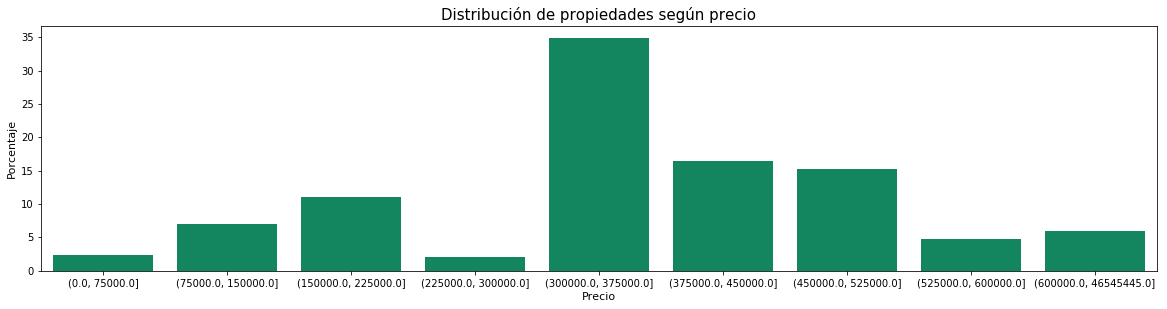

In [274]:
maskNotNull_price= data['price_aprox_usd_clean'].notnull()
precioMaximo=data['price_aprox_usd_clean'].max()
bins= [0,75000,150000,225000,300000,375000,450000, 525000, 600000, precioMaximo]

dist = pd.cut(data.loc[maskNotNull_price, 'price_aprox_usd_clean'], bins) 

f, ax = plt.subplots()
f.set_figwidth(20)
f.set_figheight(4.5)
sns.barplot(dist.unique(),(dist.value_counts()/data.loc[maskNotNull_price, 'price_aprox_usd_clean'].shape[0])*100,ax=ax , color = "#009966")
plt.title("Distribución de propiedades según precio",fontsize=15)
plt.xlabel("Precio",fontsize=11)
plt.ylabel("Porcentaje",fontsize=11)

Análisis de outliers.   
  
Debido a que pueden existir significativas diferencias de valor entre las propiedades según el tipo de propiedad y la ciudad donde se ubican, se calculan valores límites para determinar outliers a partir de estas variables. Esta consideración es tenida en cuenta en todos los procesos de "Análisis de outliers"

In [275]:
data['outliers_Price'] = None
data['ciudad_sinNulos'] = data['ciudad'].fillna("-")
data['auxiliar_Outliers'] = data['property_type']+data['provincia']+data['ciudad_sinNulos']
for i in data['auxiliar_Outliers'].unique():
    rangoInterquartil_price= data.loc[data['auxiliar_Outliers']==i,'price_aprox_usd_clean'].quantile(0.75) - data.loc[data['auxiliar_Outliers']==i,'price_aprox_usd_clean'].quantile(0.25)
    umbral_lower_Price = data.loc[data['auxiliar_Outliers']==i,'price_aprox_usd_clean'].quantile(0.25) - rangoInterquartil_price*1.5
    umbral_upper_Price = data.loc[data['auxiliar_Outliers']==i,'price_aprox_usd_clean'].quantile(0.75) + rangoInterquartil_price*1.5


    data.loc[maskNotNull_price & (data['auxiliar_Outliers']==i), 'outliers_Price']= data.loc[maskNotNull_price & (data['auxiliar_Outliers']==i), 'price_aprox_usd_clean'].apply\
                                                                                    (lambda x: "Outlier superior" if x >umbral_upper_Price else(
                                                                                 "Outlier inferior" if x<umbral_lower_Price else 
                                                                                 "No es outlier"))

outliers_Price = data['outliers_Price']
data = data.drop(columns = ['outliers_Price','ciudad_sinNulos'])
pd.DataFrame(round((outliers_Price.value_counts() / outliers_Price[maskNotNull_price].shape[0])*100,1))

,outliers_Price
No es outlier,93.3
Outlier superior,6.7
Outlier inferior,0.0


Se reemplaza a los outliers por nulos

In [276]:
maskOutliers= outliers_Price !="No es outlier"
data.loc[maskOutliers,'price_aprox_usd_clean'] = np.NaN

Visualización sin outliers

Text(0,0.5,'Porcentaje')

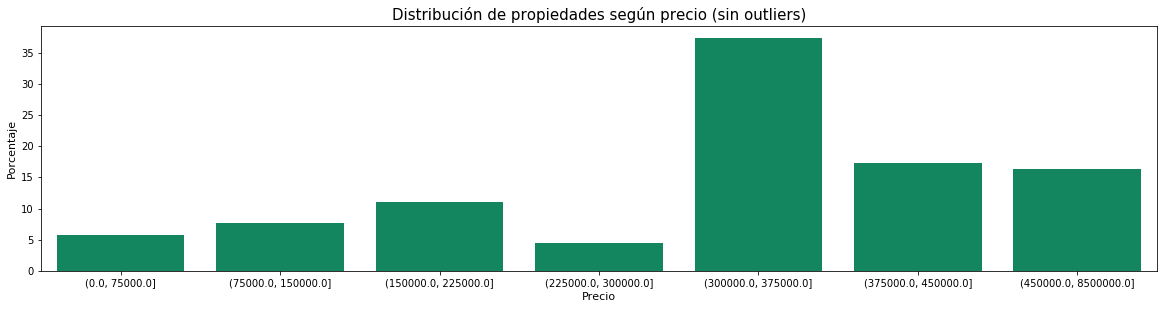

In [277]:
maskNotNull_price= data['price_aprox_usd_clean'].notnull()
precioMaximo=data['price_aprox_usd_clean'].max()
bins= [0,75000,150000,225000,300000,375000,450000, precioMaximo]

dist = pd.cut(data.loc[maskNotNull_price, 'price_aprox_usd_clean'], bins) 

f, ax = plt.subplots()
f.set_figwidth(20)
f.set_figheight(4.5)
sns.barplot(dist.unique(),(dist.value_counts()/data.loc[maskNotNull_price, 'price_aprox_usd_clean'].shape[0])*100,ax=ax , color = "#009966")
plt.title("Distribución de propiedades según precio (sin outliers)",fontsize=15)
plt.xlabel("Precio",fontsize=11)
plt.ylabel("Porcentaje",fontsize=11)

Text(0,0.5,'Precio')

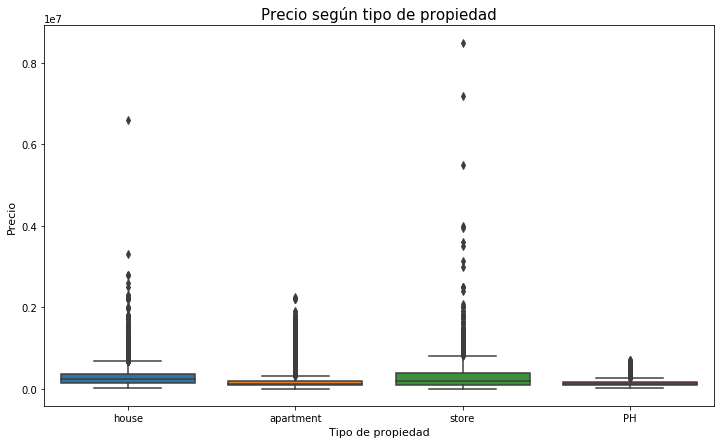

In [278]:
maskNotNull_Rooms = data['price_aprox_usd_clean'].notnull()
f, ax = plt.subplots()
f.set_figwidth(12)
f.set_figheight(7)
sns.boxplot(x=data.loc[maskNotNull_Rooms,'property_type'],y=data.loc[maskNotNull_Rooms,'price_aprox_usd_clean'])
plt.title("Precio según tipo de propiedad",fontsize=15)
plt.xlabel("Tipo de propiedad",fontsize=11)
plt.ylabel("Precio",fontsize=11)

---
<b><a id='section_2_4'>2.4. Columna 'rooms'</a>  </b>

In [279]:
data['rooms_clean'] = data['rooms']

Análisis de nulos y valores

In [280]:
data_describe.loc[data_describe.index.isin(['rooms']),:]

,type,Porcentaje de nulos,Nulos,Valores distintos,Ejemplos
rooms,float64,0.61,73830,32,"[nan, 1.0, 4.0, 3.0, 2.0, 6.0, 5.0, 10.0, 7.0,..."


Completamos los nulos de la columna 'rooms' con datos extraidos de la columna 'descripcion' y 'title'

In [281]:
#Primer pattern
regexAmbientes = re.compile('(?P<numero>\d{1})\s?(amb)')

#Regex en la columna 'descripcion'
MatchsAmbientes = data['description_lower'].apply(lambda x: x if x is np.NaN else regexAmbientes.search(x))
maskRooms_NullsAndMatch = data['rooms'].isnull() & MatchsAmbientes.notnull()
data.loc[maskRooms_NullsAndMatch, 'rooms_clean'] = MatchsAmbientes[maskRooms_NullsAndMatch].apply(lambda x: float(x.group("numero")))
#Regex en la columna 'title'
MatchsAmbientes = data['title_lower'].apply(lambda x: x if x is np.NaN else regexAmbientes.search(x))
maskRooms_NullsAndMatch = data['rooms_clean'].isnull() & MatchsAmbientes.notnull()
data.loc[maskRooms_NullsAndMatch, 'rooms_clean'] = MatchsAmbientes[maskRooms_NullsAndMatch].apply(lambda x: float(x.group("numero")))

In [282]:
#Segundo pattern
regexAmbientes2 = re.compile('(?P<numeroPalabra>uno|un|dos|tres|cuatro|cinco|seis|siete|ocho)\s?(amb)')

#Definimos una función para transformar el match obtenido en el search en un número
def MatchToNumber(x):
    numeroStr = x.group("numeroPalabra")
    dictAmbientes = {'un': 1, 'uno':1,'dos':2, 'tres':3, 'cuatro':4, 'cinco': 5, 'seis': 6, 'seís':6, 'siete': 7, 'ocho': 8, 'nueve': 9}
    resultado = dictAmbientes[numeroStr]
    return resultado

#Regex en la columna 'descripcion'
MatchsAmbientes = data['description_lower'].apply(lambda x: x if x is np.NaN else regexAmbientes2.search(x))
maskRooms_NullsAndMatch = data['rooms_clean'].isnull() & MatchsAmbientes.notnull()
data.loc[maskRooms_NullsAndMatch, 'rooms_clean'] = MatchsAmbientes[maskRooms_NullsAndMatch].apply(MatchToNumber)

#Regex en la columna 'title'
MatchsAmbientes = data['title_lower'].apply(lambda x: x if x is np.NaN else regexAmbientes2.search(x))
maskRooms_NullsAndMatch = data['rooms_clean'].isnull() & MatchsAmbientes.notnull()
data.loc[maskRooms_NullsAndMatch, 'rooms_clean'] = MatchsAmbientes[maskRooms_NullsAndMatch].apply(MatchToNumber)

In [283]:
#Tercer pattern
regexAmbientes3 = re.compile('(?P<numero>\d{1})\s?(dorm|cuarto|hab)')
#Debido a que este Pattern considera únicamente dormitorios/habitaciones, se le agrega 1 habitación a todos los matchs

#Regex en la columna 'descripcion'
MatchsAmbientes = data['description_lower'].apply(lambda x: x if x is np.NaN else regexAmbientes3.search(x))
maskRooms_NullsAndMatch = data['rooms'].isnull() & MatchsAmbientes.notnull()
data.loc[maskRooms_NullsAndMatch, 'rooms_clean'] = MatchsAmbientes[maskRooms_NullsAndMatch].apply(lambda x: float(x.group("numero"))+1)
#Regex en la columna 'title'
MatchsAmbientes = data['title_lower'].apply(lambda x: x if x is np.NaN else regexAmbientes3.search(x))
maskRooms_NullsAndMatch = data['rooms_clean'].isnull() & MatchsAmbientes.notnull()
data.loc[maskRooms_NullsAndMatch, 'rooms_clean'] = MatchsAmbientes[maskRooms_NullsAndMatch].apply(lambda x: float(x.group("numero"))+1)


In [284]:
#Cuarto pattern
regexAmbientes4 = re.compile('(?P<numeroPalabra>un|1|mono)\s?(amb)')

#Regex en la columna 'descripcion'
MatchsAmbientes = data['description_lower'].apply(lambda x: x if x is np.NaN else regexAmbientes4.search(x))
maskRooms_NullsAndMatch = data['rooms_clean'].isnull() & MatchsAmbientes.notnull()
data.loc[maskRooms_NullsAndMatch, 'rooms_clean'] = MatchsAmbientes[maskRooms_NullsAndMatch].apply(lambda x: float(1.0))

#Regex en la columna 'title'
MatchsAmbientes = data['title_lower'].apply(lambda x: x if x is np.NaN else regexAmbientes4.search(x))
maskRooms_NullsAndMatch = data['rooms_clean'].isnull() & MatchsAmbientes.notnull()
data.loc[maskRooms_NullsAndMatch, 'rooms_clean'] = MatchsAmbientes[maskRooms_NullsAndMatch].apply(lambda x: float(1.0))

In [285]:
#Quinto pattern
regexAmbientes5 = re.compile('(?P<numeroPalabra>un|dos|tres|cuatro|cinco|seis|siete|ocho)\s?(dorm|cuarto|hab)')
#Debido a que este Pattern considera únicamente dormitorios/habitaciones, se le agrega 1 habitación a todos los matchs

#Regex en la columna 'descripcion'
MatchsAmbientes = data['description_lower'].apply(lambda x: x if x is np.NaN else regexAmbientes5.search(x))
maskRooms_NullsAndMatch = data['rooms_clean'].isnull() & MatchsAmbientes.notnull()
data.loc[maskRooms_NullsAndMatch, 'rooms_clean'] = MatchsAmbientes[maskRooms_NullsAndMatch].apply(lambda x: MatchToNumber(x)+1)

#Regex en la columna 'title'
MatchsAmbientes = data['title_lower'].apply(lambda x: x if x is np.NaN else regexAmbientes5.search(x))
maskRooms_NullsAndMatch = data['rooms_clean'].isnull() & MatchsAmbientes.notnull()
data.loc[maskRooms_NullsAndMatch, 'rooms_clean'] = MatchsAmbientes[maskRooms_NullsAndMatch].apply(lambda x: MatchToNumber(x)+1)

In [286]:
print("Columna 'rooms'")
print("Cantidad de nulos antes del regex:", data['rooms'].isnull().sum(), "("+str(round((data['rooms'].isnull().sum()/data.shape[0])*100,1))+"%)")
print("Cantidad de nulos después del regex:", data['rooms_clean'].isnull().sum(),"("+str(round((data['rooms_clean'].isnull().sum()/data.shape[0])*100,1))+"%)")

Columna 'rooms'
Cantidad de nulos antes del regex: 59344 (58.1%)
Cantidad de nulos después del regex: 11189 (11.0%)


Visualización

Text(0,0.5,'Cuartos')

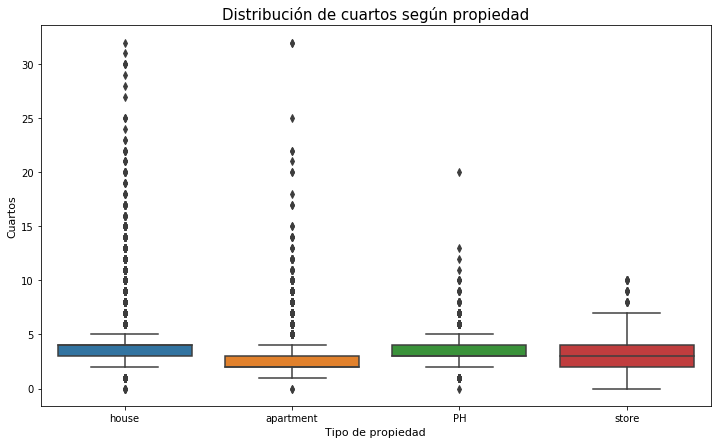

In [287]:
maskNotNull_Rooms = data['rooms_clean'].notnull()
f, ax = plt.subplots()
f.set_figwidth(12)
f.set_figheight(7)
sns.boxplot(x=data.loc[maskNotNull_Rooms,'property_type'],y=data.loc[maskNotNull_Rooms,'rooms_clean'])
plt.title("Distribución de cuartos según propiedad",fontsize=15)
plt.xlabel("Tipo de propiedad",fontsize=11)
plt.ylabel("Cuartos",fontsize=11)

Análisis de outliers

In [288]:
data['outliers_rooms'] = None
for i in data['property_type'].unique():
    rangoInterquartil_rooms= data.loc[data['property_type']==i,'rooms_clean'].quantile(0.75) - data.loc[data['property_type']==i,'rooms_clean'].quantile(0.25)
    umbral_lower_rooms = data.loc[data['property_type']==i,'rooms_clean'].quantile(0.25) - rangoInterquartil_rooms*1.5
    umbral_upper_rooms = data.loc[data['property_type']==i,'rooms_clean'].quantile(0.75) + rangoInterquartil_rooms*1.5


    data.loc[maskNotNull_Rooms & (data['property_type']==i), 'outliers_rooms']= data.loc[maskNotNull_Rooms & (data['property_type']==i), 'rooms_clean'].apply\
                                                                                    (lambda x: "Outlier superior" if x >umbral_upper_rooms else(
                                                                                 "Outlier inferior" if x<umbral_lower_rooms else 
                                                                                 "No es outlier"))

outliers_rooms = data['outliers_rooms']
data = data.drop(columns = ['outliers_rooms'])
pd.DataFrame(round((outliers_rooms.value_counts() / outliers_rooms[maskNotNull_Rooms].shape[0])*100,1))

,outliers_rooms
No es outlier,93.4
Outlier superior,6.0
Outlier inferior,0.6


Se reemplaza a los outliers por nulos

In [289]:
maskOutliers= outliers_rooms !="No es outlier"
data.loc[maskOutliers,'rooms_clean'] = np.NaN

Le imputamos a los datos que los nulos el valor promedio de cuartos según su tipo de propiedad.
Los nulos proveniente de los outliers quedan nulos

In [290]:
maskOldNulls = maskNotNull_Rooms ==False 

In [291]:
meanByProperty_rooms = pd.DataFrame(data.groupby('property_type')['rooms_clean'].mean())
meanByProperty_rooms.columns = ['rooms_clean_mean']
meanByProperty_rooms['rooms_clean_mean'] = meanByProperty_rooms['rooms_clean_mean'].apply(lambda x: math.floor(x))
meanByProperty_rooms.sort_values(by = 'rooms_clean_mean', ascending=False)

,rooms_clean_mean
property_type,
PH,3
house,3
apartment,2
store,2


In [292]:
data= data.merge(meanByProperty_rooms, on='property_type')

In [293]:
data.loc[maskOldNulls,'rooms_clean'] = data.loc[maskOldNulls,'rooms_clean_mean'] 
data = data.drop(columns=['rooms_clean_mean'])

Visualización sin outliers

Text(0,0.5,'Cuartos')

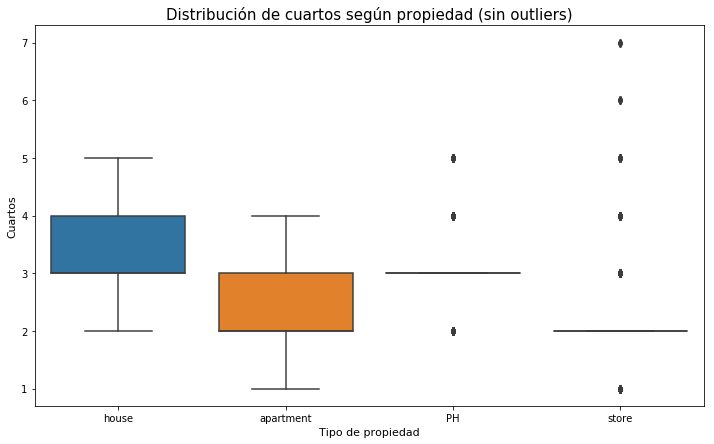

In [294]:
f, ax = plt.subplots()
f.set_figwidth(12)
f.set_figheight(7)
sns.boxplot(x=data['property_type'],y=data['rooms_clean'])
plt.title("Distribución de cuartos según propiedad (sin outliers)",fontsize=15)
plt.xlabel("Tipo de propiedad",fontsize=11)
plt.ylabel("Cuartos",fontsize=11)

---
<b><a id='section_2_5'>2.5. Columna 'floor'</a> </b>

In [295]:
data['floor_clean'] = data['floor']

Análisis de nulos y valores

In [296]:
data_describe.loc[data_describe.index.isin(['floor']),:]

,type,Porcentaje de nulos,Nulos,Valores distintos,Ejemplos
floor,float64,0.93,113321,183,"[nan, 5.0, 1.0, 2.0, 3.0, 12.0, 6.0, 4.0, 7.0,..."


In [297]:
print("Campos con información en la columna 'floor' según tipo de propiedad")
pd.DataFrame(data.groupby('property_type')['floor'].apply(lambda x: x.notnull().sum()))

Campos con información en la columna 'floor' según tipo de propiedad


,floor
property_type,
PH,385
apartment,5589
house,624
store,39


Se decide contemplar la variable 'floor' únicamente para los departamentos. Se le imputa valor nulo a los otros tipo de propiedad

In [298]:
maskNotApartment = data['property_type'] != 'apartment'
data.loc[maskNotApartment, 'floor_clean'] = np.NaN
pd.DataFrame(data.groupby('property_type')['floor_clean'].apply(lambda x: x.notnull().sum()))

,floor_clean
property_type,
PH,0
apartment,5589
house,0
store,0


Completamos los nulos de la columna 'floor_clean' con datos extraidos de la columna 'descripcion' y 'title'

In [299]:
maskApartment = data['property_type'] == 'apartment'

In [300]:
#Primer pattern
regexFloor = re.compile('(?P<numeroPiso>\d\d?)\s?(^er|er|do|to|mo|ro|avo|vo|no)')

#Regex en la columna 'descripcion'
MatchsFloor = data['description_lower'].apply(lambda x: x if x is np.NaN else regexFloor.search(x))
maskFloor_NullsAndMatch = data['floor_clean'].isnull() & MatchsFloor.notnull()
data.loc[maskFloor_NullsAndMatch, 'floor_clean'] = MatchsFloor[maskFloor_NullsAndMatch].apply(lambda x: float(x.group("numeroPiso")))

#Regex en la columna 'title'
MatchsFloor = data['title_lower'].apply(lambda x: x if x is np.NaN else regexFloor.search(x))
maskFloor_NullsAndMatch = data['floor_clean'].isnull() & MatchsFloor.notnull()
data.loc[maskFloor_NullsAndMatch, 'floor_clean'] = MatchsFloor[maskFloor_NullsAndMatch].apply(lambda x: float(x.group("numeroPiso")))

In [301]:
#Segundo pattern
regexFloor2 = re.compile('(?P<numeroPiso>\d\d?)\s?\º?\s?(piso)')

#Regex en la columna 'descripcion'
MatchsFloor = data['description_lower'].apply(lambda x: x if x is np.NaN else regexFloor2.search(x))
maskFloor_NullsAndMatch = data['floor_clean'].isnull() & MatchsFloor.notnull()
data.loc[maskFloor_NullsAndMatch, 'floor_clean'] = MatchsFloor[maskFloor_NullsAndMatch].apply(lambda x: float(x.group("numeroPiso")))

#Regex en la columna 'title'
MatchsFloor = data['title_lower'].apply(lambda x: x if x is np.NaN else regexFloor2.search(x))
maskFloor_NullsAndMatch = data['floor_clean'].isnull() & MatchsFloor.notnull()
data.loc[maskFloor_NullsAndMatch, 'floor_clean'] = MatchsFloor[maskFloor_NullsAndMatch].apply(lambda x: float(x.group("numeroPiso")))

In [302]:
#Tercer pattern
regexFloor3 = re.compile('(piso)\s?(?P<numeroPiso>\d\d?)')

#Regex en la columna 'descripcion'
MatchsFloor = data['description_lower'].apply(lambda x: x if x is np.NaN else regexFloor3.search(x))
maskFloor_NullsAndMatch = data['floor_clean'].isnull() & MatchsFloor.notnull()
data.loc[maskFloor_NullsAndMatch, 'floor_clean'] = MatchsFloor[maskFloor_NullsAndMatch].apply(lambda x: float(x.group("numeroPiso")))

#Regex en la columna 'title'
MatchsFloor = data['title_lower'].apply(lambda x: x if x is np.NaN else regexFloor3.search(x))
maskFloor_NullsAndMatch = data['floor_clean'].isnull() & MatchsFloor.notnull()
data.loc[maskFloor_NullsAndMatch, 'floor_clean'] = MatchsFloor[maskFloor_NullsAndMatch].apply(lambda x: float(x.group("numeroPiso")))

In [303]:
#Cuarto pattern
regexFloor3 = re.compile('pb|plantabaja|planta baja')

#Regex en la columna 'descripcion'
MatchsFloor = data['description_lower'].apply(lambda x: x if x is np.NaN else regexFloor3.search(x))
maskFloor_NullsAndMatch = data['floor_clean'].isnull() & MatchsFloor.notnull()
data.loc[maskFloor_NullsAndMatch, 'floor_clean'] = MatchsFloor[maskFloor_NullsAndMatch].apply(lambda x: float(0))

#Regex en la columna 'title'
MatchsFloor = data['title_lower'].apply(lambda x: x if x is np.NaN else regexFloor3.search(x))
maskFloor_NullsAndMatch = data['floor_clean'].isnull() & MatchsFloor.notnull()
data.loc[maskFloor_NullsAndMatch, 'floor_clean'] = MatchsFloor[maskFloor_NullsAndMatch].apply(lambda x: float(0))

In [304]:
data['floor_clean'] = data['floor_clean'].astype(float)

In [305]:
print("Columna 'floor'")
print("Cantidad de nulos antes del regex:", data.loc[maskApartment,'floor'].isnull().sum(), "("+str(round((data.loc[maskApartment,'floor'].isnull().sum()/data.loc[maskApartment,:].shape[0])*100,1))+"%)")
print("Cantidad de nulos después del regex:", data.loc[maskApartment,'floor_clean'].isnull().sum(),"("+str(round((data.loc[maskApartment,'floor_clean'].isnull().sum()/data.loc[maskApartment,:].shape[0])*100,1))+"%)")

Columna 'floor'
Cantidad de nulos antes del regex: 49541 (89.9%)
Cantidad de nulos después del regex: 23149 (42.0%)


Visualización

Text(0,0.5,'Pisos')

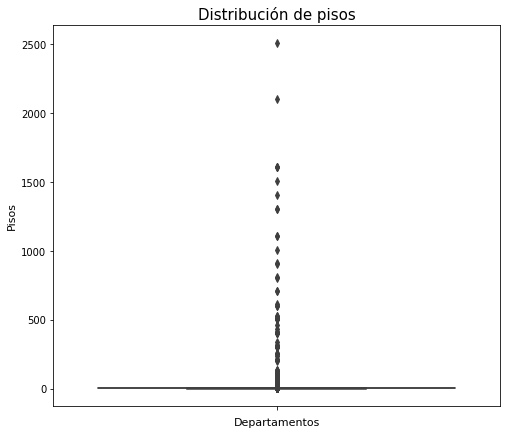

In [306]:
maskNotNull_Floor = data['floor_clean'].notnull()
f, ax = plt.subplots()
f.set_figwidth(8)
f.set_figheight(7)
sns.boxplot(y=data.loc[maskNotNull_Floor,'floor_clean'])
plt.title("Distribución de pisos",fontsize=15)
plt.xlabel("Departamentos",fontsize=11)
plt.ylabel("Pisos",fontsize=11)

Análisis de outliers. Se consideran nulos a los pisos superiores a 20.

In [307]:
maskOutliers = data['floor_clean'] > 20
maskOutliers.value_counts()

False    100946
True       1208
Name: floor_clean, dtype: int64

Se reemplaza los outliers por nulos

In [308]:
maskOutliers = data['floor_clean'] > 20
data.loc[maskOutliers,'floor_clean'] = np.NaN

Visualización sin outliers

Text(0,0.5,'Pisos')

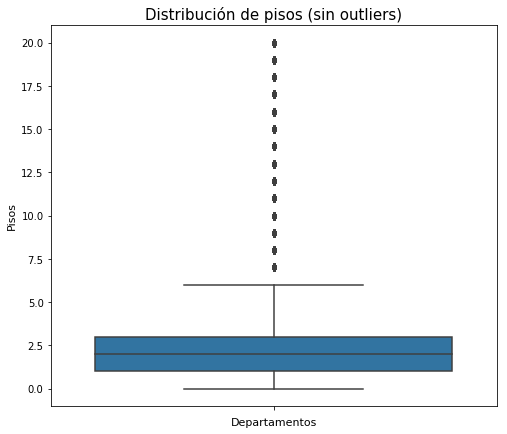

In [309]:
f, ax = plt.subplots()
f.set_figwidth(8)
f.set_figheight(7)
sns.boxplot(y=data['floor_clean'])
plt.title("Distribución de pisos (sin outliers)",fontsize=15)
plt.xlabel("Departamentos",fontsize=11)
plt.ylabel("Pisos",fontsize=11)

---
<b><a id='section_2_6'>2.6. Columnas 'surface_total_in_m2' y 'surface_covered_in_m2'</a> </b>

In [310]:
data['surface_total_in_m2_clean'] = data['surface_total_in_m2']

Análisis de nulos y valores

In [311]:
data_describe.loc[data_describe.index.isin(['surface_covered_in_m2','surface_total_in_m2']),:]

,type,Porcentaje de nulos,Nulos,Valores distintos,Ejemplos
surface_total_in_m2,float64,0.32,39328,1688,"[55.0, nan, 35.0, 53.0, 106.0, 45.0, 65.0, 151..."
surface_covered_in_m2,float64,0.16,19907,996,"[40.0, nan, 55.0, 35.0, 78.0, 60.0, 36.0, 30.0..."


In [312]:
maskNull_coveredAndTotal = data['surface_covered_in_m2'].isnull() & data['surface_total_in_m2'].isnull()
print("Cantidad de nulos que coinciden:",maskNull_coveredAndTotal.value_counts()[True])

Cantidad de nulos que coinciden: 9521


Se opta por completar la columna 'surface_total_in_m2' mediante el siguiente proceso:  
1- Imputar datos de acuerdo a la proporción media entre  'surface_covered_in_m2'  y 'surface_total_in_m2'  
2- Completamos los nulos restantes con datos extraidos de la columna 'descripcion' y 'title'

In [313]:
maskNotNull_TotalAndCovered = data['surface_covered_in_m2'].notnull() & data['surface_total_in_m2'].notnull()
data['covered_pct'] = data.loc[maskNotNull_TotalAndCovered, 'surface_covered_in_m2'] / data.loc[maskNotNull_TotalAndCovered, 'surface_total_in_m2'] 
data['covered_pct'] = data['covered_pct'].apply(lambda x: 1 if x>1 else x)
meanByProperty = pd.DataFrame(data.groupby('property_type')['covered_pct'].mean())
meanByProperty.columns = ['covered_pct_mean']
print("Las casas son las que menos metros cuadrados tienen cubierto")
meanByProperty.sort_values(by = 'covered_pct_mean', ascending=False)

Las casas son las que menos metros cuadrados tienen cubierto


,covered_pct_mean
property_type,
store,0.938959
apartment,0.887247
PH,0.808392
house,0.691308


In [314]:
data = data.merge(meanByProperty, on='property_type')

In [315]:
maskFill = data['surface_covered_in_m2'].notnull() & data['surface_total_in_m2'].isnull()
surface_total_parche = data.loc[maskFill,'surface_covered_in_m2'] / data.loc[maskFill,'covered_pct_mean']
data.loc[maskFill, 'surface_total_in_m2_clean'] = surface_total_parche[maskFill] 

In [316]:
print("Columna 'surface_total_in_m2'")
print("Cantidad de nulos antes de la imputación:", data['surface_total_in_m2'].isnull().sum(), "("+str(round((data['surface_total_in_m2'].isnull().sum()/data.shape[0])*100,1))+"%)")
print("Cantidad de nulos después de la imputación:", data['surface_total_in_m2_clean'].isnull().sum(),"("+str(round((data['surface_total_in_m2_clean'].isnull().sum()/data.shape[0])*100,1))+"%)")

Columna 'surface_total_in_m2'
Cantidad de nulos antes de la imputación: 33439 (32.7%)
Cantidad de nulos después de la imputación: 9521 (9.3%)


In [317]:
#Pattern
regexSurface = re.compile('(?P<mts2>\d\d?\d?\d?)\s?(?P<metros>mts|mt|metros|mt2|m2|m|mts2|m2c|mÂ²|mts²)')

#Regex en la columna 'descripcion'
MatchsSurface = data['description_lower'].apply(lambda x: x if x is np.NaN else regexSurface.search(x))
maskSurface_NullsAndMatch = data['surface_total_in_m2_clean'].isnull() & MatchsSurface.notnull()
data.loc[maskSurface_NullsAndMatch, 'surface_total_in_m2_clean'] = MatchsSurface[maskSurface_NullsAndMatch].apply(lambda x: float(x.group("mts2")))

#Regex en la columna 'title'
MatchsSurface = data['title_lower'].apply(lambda x: x if x is np.NaN else regexSurface.search(x))
maskSurface_NullsAndMatch = data['surface_total_in_m2_clean'].isnull() & MatchsSurface.notnull()
data.loc[maskSurface_NullsAndMatch, 'surface_total_in_m2_clean'] = MatchsSurface[maskSurface_NullsAndMatch].apply(lambda x: float(x.group("mts2")))

Se considera que una propiedad no puede tener menos de 20 mts cuadrados

In [318]:
data['surface_total_in_m2_clean'] = data['surface_total_in_m2_clean'].apply(lambda x: np.NaN if x < 20 else x)

In [319]:
print("Columna 'surface_total_in_m2'")
print("Cantidad de nulos antes del regex:", data['surface_total_in_m2'].isnull().sum(), "("+str(round((data['surface_total_in_m2'].isnull().sum()/data.shape[0])*100,1))+"%)")
print("Cantidad de nulos después del regex:", data['surface_total_in_m2_clean'].isnull().sum(),"("+str(round((data['surface_total_in_m2_clean'].isnull().sum()/data.shape[0])*100,1))+"%)")

Columna 'surface_total_in_m2'
Cantidad de nulos antes del regex: 33439 (32.7%)
Cantidad de nulos después del regex: 7298 (7.1%)


Visualización

Text(0,0.5,'Metros cuadrados')

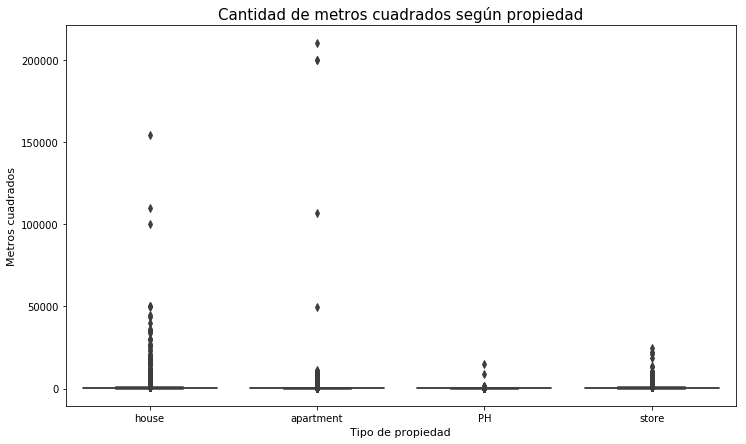

In [320]:
maskNotNull_Surface = data['surface_total_in_m2_clean'].notnull()
f, ax = plt.subplots()
f.set_figwidth(12)
f.set_figheight(7)
sns.boxplot(x=data.loc[maskNotNull_Rooms,'property_type'],y=data.loc[maskNotNull_Rooms,'surface_total_in_m2_clean'])
plt.title("Cantidad de metros cuadrados según propiedad",fontsize=15)
plt.xlabel("Tipo de propiedad",fontsize=11)
plt.ylabel("Metros cuadrados",fontsize=11)

Análisis de outliers.  

In [321]:
data['outliers_Surface'] = None
for i in data['property_type'].unique():
    rangoInterquartil_Surface= data.loc[data['property_type']==i,'surface_total_in_m2_clean'].quantile(0.75) - data.loc[data['property_type']==i,'surface_total_in_m2_clean'].quantile(0.25)
    umbral_lower_Surface = data.loc[data['property_type']==i,'surface_total_in_m2_clean'].quantile(0.25) - rangoInterquartil_Surface*1.5
    umbral_upper_Surface = data.loc[data['property_type']==i,'surface_total_in_m2_clean'].quantile(0.75) + rangoInterquartil_Surface*1.5


    data.loc[maskNotNull_Surface & (data['property_type']==i), 'outliers_Surface']= data.loc[maskNotNull_Surface & (data['property_type']==i), 'surface_total_in_m2_clean'].apply\
                                                                                    (lambda x: "Outlier superior" if x >umbral_upper_Surface else(
                                                                                 "Outlier inferior" if x<umbral_lower_Surface else 
                                                                                 "No es outlier"))

outliers_Surface = data['outliers_Surface']
data = data.drop(columns = ['outliers_Surface'])
pd.DataFrame(round((outliers_Surface.value_counts() / outliers_Surface[maskNotNull_Surface].shape[0])*100,1))

,outliers_Surface
No es outlier,91.9
Outlier superior,8.1


Se reemplaza a los outliers por nulos

In [322]:
maskOutliers= outliers_Surface !="No es outlier"
data.loc[maskOutliers,'surface_total_in_m2_clean'] = np.NaN

Visualización sin outliers

Text(0,0.5,'Metros cuadrados')

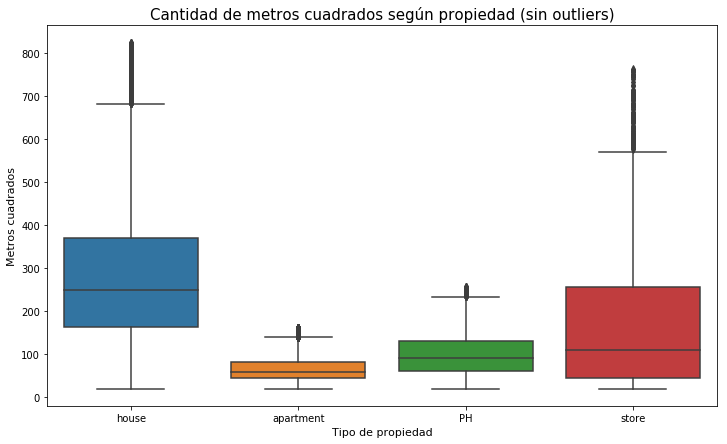

In [323]:
f, ax = plt.subplots()
f.set_figwidth(12)
f.set_figheight(7)

sns.boxplot(x=data['property_type'],y=data['surface_total_in_m2_clean'])
plt.title("Cantidad de metros cuadrados según propiedad (sin outliers)",fontsize=15)
plt.xlabel("Tipo de propiedad",fontsize=11)
plt.ylabel("Metros cuadrados",fontsize=11)

---
<b><a id='section_2_7'>2.7. Columna 'price_usd_per_m2'</a> </b>

Análisis de nulos y valores

In [324]:
data_describe.loc[data_describe.index.isin(['price_usd_per_m2']),:]

,type,Porcentaje de nulos,Nulos,Valores distintos,Ejemplos
price_usd_per_m2,float64,0.43,52603,25568,"[1127.2727272727273, nan, 1309.090909090909, 1..."


Se reemplaza la columna 'price_usd_per_m2' por el cociente de las columnas 'price_aprox_usd_clean' y 'surface_total_in_m2_clean' para que sea consistente con los cambios realizados

In [325]:
maskNotNull = data['price_aprox_usd_clean'].notnull() & data['surface_total_in_m2_clean'].notnull()
data['price_usd_per_m2_clean'] = (data.loc[maskNotNull, 'price_aprox_usd_clean'] / data.loc[maskNotNull, 'surface_total_in_m2_clean']).round(0)

Visualización

Text(0,0.5,'Precio por metro cuadrado')

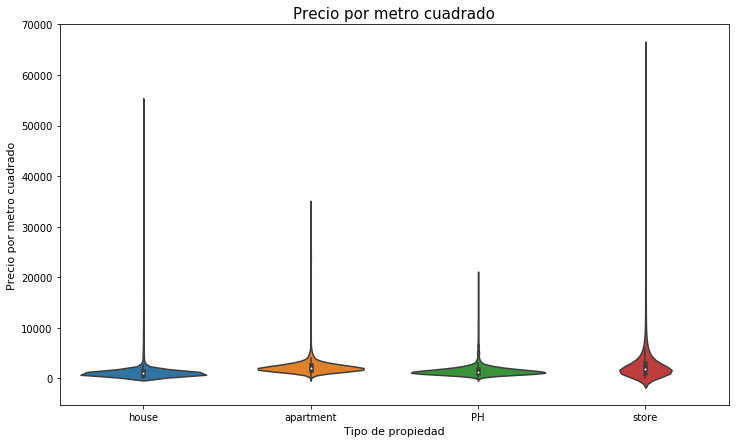

In [326]:
f, ax = plt.subplots()
f.set_figwidth(12)
f.set_figheight(7)
sns.violinplot(data['property_type'], data['price_usd_per_m2_clean'])
plt.title("Precio por metro cuadrado",fontsize=15)
plt.xlabel("Tipo de propiedad",fontsize=11)
plt.ylabel("Precio por metro cuadrado",fontsize=11)

Análisis de outliers

In [327]:
maskNotNull_pricexmt2 = data['price_usd_per_m2_clean'].notnull()
data['outliers_pricexmt2'] = None
for i in data['property_type'].unique():
    rangoInterquartil_pricexmt2= data.loc[data['property_type']==i,'price_usd_per_m2_clean'].quantile(0.75) - data.loc[data['property_type']==i,'price_usd_per_m2_clean'].quantile(0.25)
    umbral_lower_pricexmt2 = data.loc[data['property_type']==i,'price_usd_per_m2_clean'].quantile(0.25) - rangoInterquartil_pricexmt2*1.5
    umbral_upper_pricexmt2 = data.loc[data['property_type']==i,'price_usd_per_m2_clean'].quantile(0.75) + rangoInterquartil_pricexmt2*1.5


    data.loc[maskNotNull_pricexmt2 & (data['property_type']==i), 'outliers_pricexmt2']= data.loc[maskNotNull_pricexmt2 & (data['property_type']==i), 'price_usd_per_m2_clean'].apply\
                                                                                    (lambda x: "Outlier superior" if x >umbral_upper_pricexmt2 else(
                                                                                 "Outlier inferior" if x<umbral_lower_pricexmt2 else 
                                                                                 "No es outlier"))

outliers_pricexmt2 = data['outliers_pricexmt2']
data = data.drop(columns = ['outliers_pricexmt2'])
pd.DataFrame(round((outliers_pricexmt2.value_counts() / outliers_pricexmt2[maskNotNull_pricexmt2].shape[0])*100,1))

,outliers_pricexmt2
No es outlier,95.3
Outlier superior,4.7
Outlier inferior,0.0


Se reemplaza a los outliers por nulos

In [328]:
maskOutliers= outliers_pricexmt2 !="No es outlier"
data.loc[maskOutliers,'price_usd_per_m2_clean'] = np.NaN

Visualización sin outliers

Text(0,0.5,'Precio por metro cuadrado')

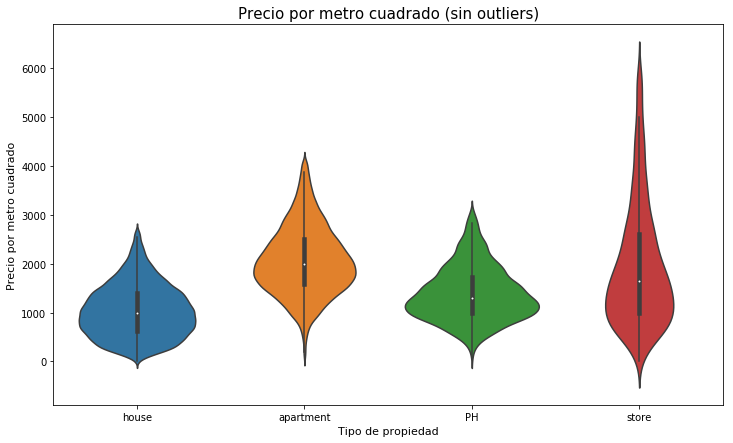

In [329]:
f, ax = plt.subplots()
f.set_figwidth(12)
f.set_figheight(7)
sns.violinplot(data['property_type'], data['price_usd_per_m2_clean'])
plt.title("Precio por metro cuadrado (sin outliers)",fontsize=15)
plt.xlabel("Tipo de propiedad",fontsize=11)
plt.ylabel("Precio por metro cuadrado",fontsize=11)

---
---

<b><a id='section_3'><h4>3. Nuevas variables</h4></a></b>
<a href='#section_3_1'>3.1. Pileta</a>  
<a href='#section_3_2'>3.2. Cochera  </a>  
<a href='#section_3_3'>3.3. Barrio cerrado</a>  
<a href='#section_3_4'>3.4. Jacuzzi  </a>  
<a href='#section_3_5'>3.5. Terraza  </a>  
<a href='#section_3_6'>3.6. Quincho  </a>  
<a href='#section_3_7'>3.7. Gimnasio  </a>  
<a href='#section_3_8'>3.8. Seguridad  </a>  
<a href='#section_3_9'>3.9. A Reciclar  </a>  
<a href='#section_3_10'>3.10. De Epoca </a>  
<a href='#section_3_11'>3.11. Cantidad de Cocheras</a>  
<a href='#section_3_12'>3.12. Cantidad de baños</a>  
<a href='#section_3_13'>3.13. Balcón</a>  
<a href='#section_3_14'>3.14. A estrenar</a>  
<a href='#section_3_14'>3.14. A estrenar</a>     
<a href='#section_3_15'>3.15. Calefacción central / Losa radiante</a>  
<a href='#section_3_16'>3.16. Parque, Patio, Jardin</a>  

Definimos una función para graficar los patrones encontrados

In [330]:
data['decil'] = pd.qcut(data['price_aprox_usd_clean'],10,labels=[1,2,3,4,5,6,7,8,9,10])
def chart_type(y_value):
    chart_pattern = pd.DataFrame(data[y_value].value_counts())
    chart_pattern[y_value+" (%)"] = round(pd.DataFrame(data[y_value].value_counts())/data[y_value].shape[0]*100,2)
    
    chart_property = (data.groupby('property_type')[y_value].sum()/data.groupby('property_type')[y_value].count())*100
    chart_property = pd.DataFrame(round(chart_property,2))
    chart_property =chart_property.reset_index()
    
    chart_decil = (data.groupby('decil')[y_value].sum()/data.groupby('decil')[y_value].count())*100
    chart_decil = pd.DataFrame(round(chart_decil,2))
    chart_decil =chart_decil.reset_index()
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figwidth(12)
    f.set_figheight(4.5)
    
    ax1.pie(chart_pattern[y_value],labels=chart_pattern.index, autopct='%1.1f%%', shadow=True)  
    sns.barplot(x='property_type', y=y_value, data=chart_property, ax=ax2)
    sns.barplot(x='decil', y=y_value, data=chart_decil, color = "#009966", ax=ax3)
    
    plt.tight_layout()
    ax1.title.set_text("Patrones de \'"+y_value+"\' encontrados")
    ax2.title.set_text("Porcentaje de "+y_value+" por tipo de propiedad")
    ax3.title.set_text("Porcentaje de "+y_value+" según decil\ndel valor de la propiedad")
    return

---
<b><a id='section_3_1'>3.1. Pileta</a>  </b>

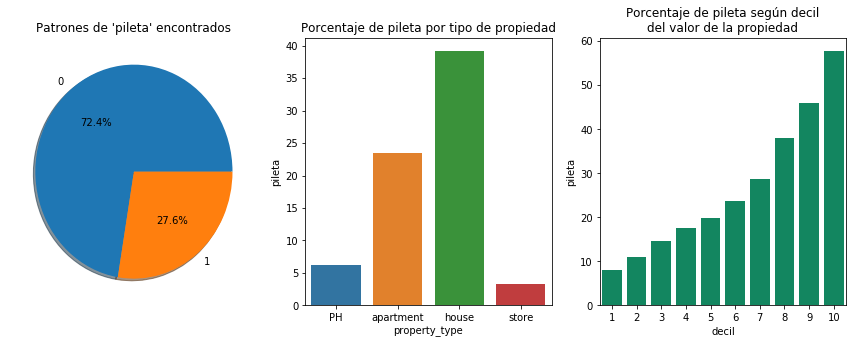

In [331]:
#Pattern
regexPileta = re.compile("(?P<pileta>pileta|picina|piscina|pisina)")

data['pileta'] = 0
#Regex en la columna 'descripcion'
MatchsPileta = data['description_lower'].apply(lambda x: x if x is np.NaN else regexPileta.search(x))
maskPileta_Match = MatchsPileta.notnull()
data.loc[maskPileta_Match, 'pileta'] = 1

#Regex en la columna 'title'
MatchsPileta = data['title_lower'].apply(lambda x: x if x is np.NaN else regexPileta.search(x))
maskPileta_Match = MatchsPileta.notnull()
data.loc[maskPileta_Match, 'pileta'] = 1

chart_type('pileta')

---
<b><a id='section_3_2'>3.2. Cochera</a>  </b>

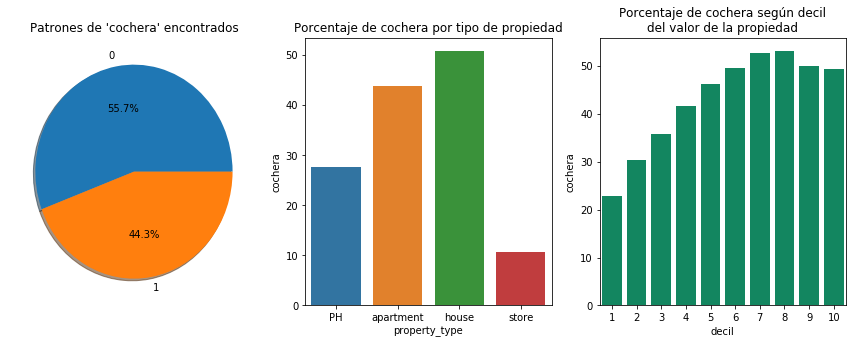

In [332]:
#Pattern
regexCochera = re.compile("(?P<cochera>cochera|garage|auto\s|automovil|vehiculo|\scoche\s|\scoches\s)")

data['cochera'] = 0
#Regex en la columna 'descripcion'
MatchsCochera = data['description_lower'].apply(lambda x: x if x is np.NaN else regexCochera.search(x))
maskCochera_Match = MatchsCochera.notnull()
data.loc[maskCochera_Match, 'cochera'] = 1

#Regex en la columna 'title'
MatchsCochera = data['title_lower'].apply(lambda x: x if x is np.NaN else regexCochera.search(x))
maskCochera_Match = MatchsCochera.notnull()
data.loc[maskCochera_Match, 'cochera'] = 1

chart_type('cochera')

---
<b><a id='section_3_3'>3.3. Barrio cerrado</a>  </b>

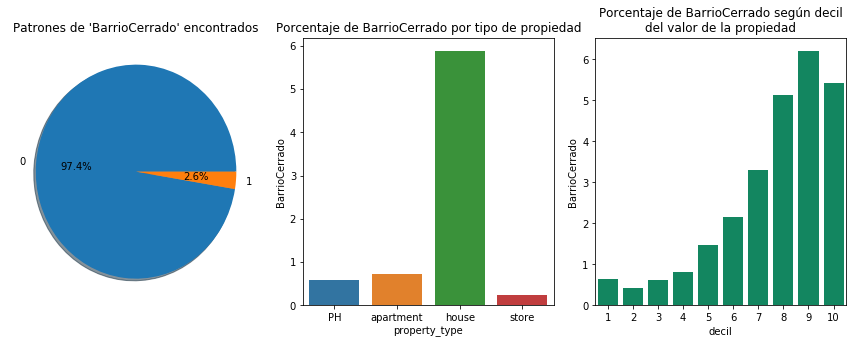

In [333]:
#Pattern
regexBarrioCerrado = re.compile("(?P<barrio>(barrio cerrado)|(barrio semicerrado)|(barrio semi cerrado)|country)")

data['BarrioCerrado'] = 0
#Regex en la columna 'descripcion'
MatchsBarrioCerrado = data['description_lower'].apply(lambda x: x if x is np.NaN else regexBarrioCerrado.search(x))
maskBarrioCerrado_Match = MatchsBarrioCerrado.notnull()
data.loc[maskBarrioCerrado_Match, 'BarrioCerrado'] = 1

#Regex en la columna 'title'
MatchsBarrioCerrado = data['title_lower'].apply(lambda x: x if x is np.NaN else regexBarrioCerrado.search(x))
maskBarrioCerrado_Match = MatchsBarrioCerrado.notnull()
data.loc[maskBarrioCerrado_Match, 'BarrioCerrado'] = 1

chart_type('BarrioCerrado')

---
<b><a id='section_3_4'>3.4. Jacuzzi</a>  </b>

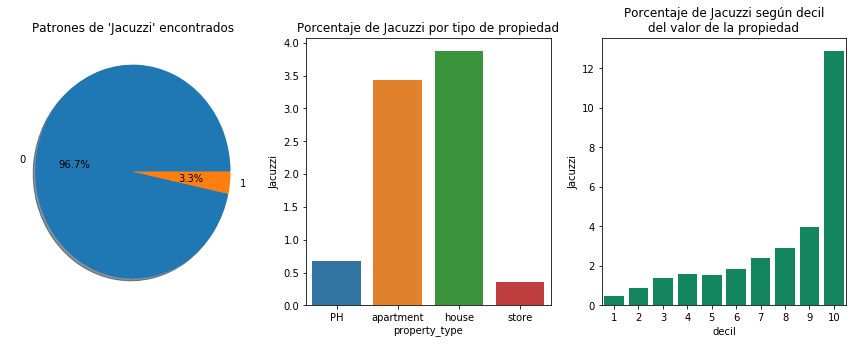

In [334]:
#Pattern
regexJacuzzi = re.compile("(?P<jacuzzi>(jacuzzi)|(suana)|(jacuzi))")

data['Jacuzzi'] = 0
#Regex en la columna 'descripcion'
MatchsJacuzzi = data['description_lower'].apply(lambda x: x if x is np.NaN else regexJacuzzi.search(x))
maskJacuzzi_Match = MatchsJacuzzi.notnull()
data.loc[maskJacuzzi_Match, 'Jacuzzi'] = 1

#Regex en la columna 'title'
MatchsJacuzzi = data['title_lower'].apply(lambda x: x if x is np.NaN else regexJacuzzi.search(x))
maskJacuzzi_Match = MatchsJacuzzi.notnull()
data.loc[maskJacuzzi_Match, 'Jacuzzi'] = 1

chart_type('Jacuzzi')

---
<b><a id='section_3_5'>3.5. Terraza</a>  </b>

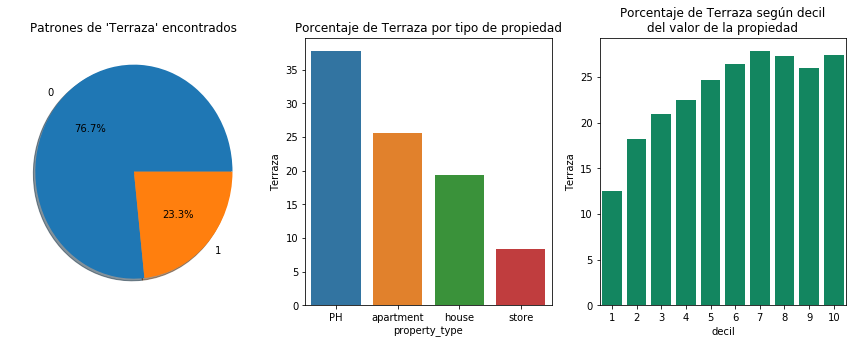

In [335]:
#Pattern
regexTerraza = re.compile("(?P<terraza>(terraza)|(terrasa)|(azotea)|(asotea))")

data['Terraza'] = 0
#Regex en la columna 'descripcion'
MatchsTerraza = data['description_lower'].apply(lambda x: x if x is np.NaN else regexTerraza.search(x))
maskTerraza_Match = MatchsTerraza.notnull()
data.loc[maskTerraza_Match, 'Terraza'] = 1

#Regex en la columna 'title'
MatchsTerraza = data['title_lower'].apply(lambda x: x if x is np.NaN else regexTerraza.search(x))
maskTerraza_Match = MatchsTerraza.notnull()
data.loc[maskTerraza_Match, 'Terraza'] = 1

chart_type('Terraza')

---
<b><a id='section_3_6'>3.6. Quincho</a>  </b>

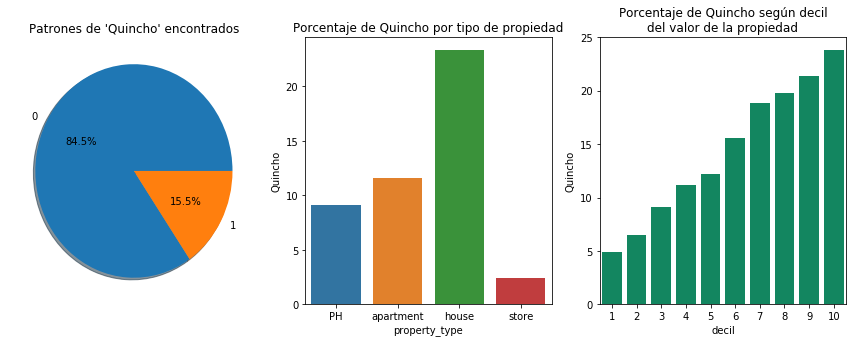

In [336]:
#Pattern
regexQuincho = re.compile("(?P<quincho>(quincho)|(kincho)|(qincho)|(\ssum\s)|(s\.u\.m\.))")

data['Quincho'] = 0
#Regex en la columna 'descripcion'
MatchsQuincho = data['description_lower'].apply(lambda x: x if x is np.NaN else regexQuincho.search(x))
maskQuincho_Match = MatchsQuincho.notnull()
data.loc[maskQuincho_Match, 'Quincho'] = 1

#Regex en la columna 'title'
MatchsQuincho = data['title_lower'].apply(lambda x: x if x is np.NaN else regexQuincho.search(x))
maskQuincho_Match = MatchsQuincho.notnull()
data.loc[maskQuincho_Match, 'Quincho'] = 1

chart_type('Quincho')

---
<b><a id='section_3_7'>3.7. Gimnasio</a>  </b>

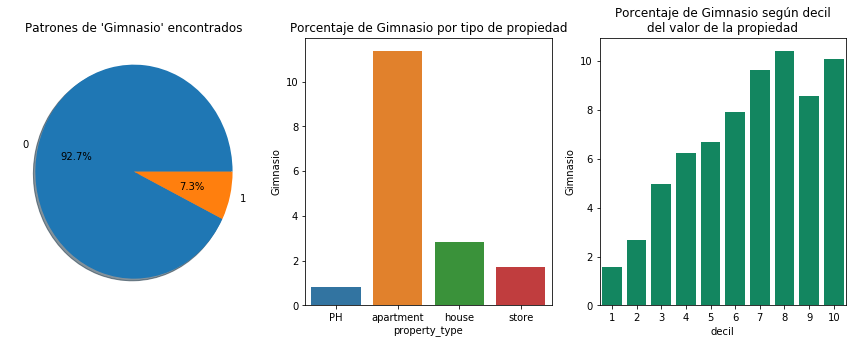

In [337]:
#Pattern
regexGimnasio = re.compile("(?P<gym>(gym)|(gimnasio)|(gimnacio))")

data['Gimnasio'] = 0
#Regex en la columna 'descripcion'
MatchsGimnasio = data['description_lower'].apply(lambda x: x if x is np.NaN else regexGimnasio.search(x))
maskGimnasio_Match = MatchsGimnasio.notnull()
data.loc[maskGimnasio_Match, 'Gimnasio'] = 1

#Regex en la columna 'title'
MatchsGimnasio = data['title_lower'].apply(lambda x: x if x is np.NaN else regexGimnasio.search(x))
maskGimnasio_Match = MatchsGimnasio.notnull()
data.loc[maskGimnasio_Match, 'Gimnasio'] = 1

chart_type('Gimnasio')

---
<b><a id='section_3_8'>3.8. Seguridad</a>  </b>

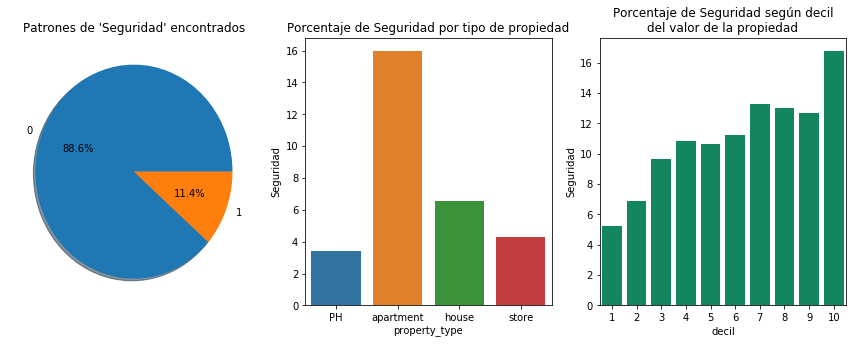

In [338]:
#Pattern
regexSeguridad = re.compile("(?P<seguridad>seguridad|vigilancia|c[a|á]maras|ojo de halc[o|ó]n|vigilador|garita|circuito cerrado|cctv|monitoreo|seg 24|24hr)+")

data['Seguridad'] = 0
#Regex en la columna 'descripcion'
MatchsSeguridad = data['description_lower'].apply(lambda x: x if x is np.NaN else regexSeguridad.search(x))
maskSeguridad_Match = MatchsSeguridad.notnull()
data.loc[maskSeguridad_Match, 'Seguridad'] = 1

#Regex en la columna 'title'
MatchsSeguridad = data['title_lower'].apply(lambda x: x if x is np.NaN else regexSeguridad.search(x))
maskSeguridad_Match = MatchsSeguridad.notnull()
data.loc[maskSeguridad_Match, 'Seguridad'] = 1

chart_type('Seguridad')

---
<b><a id='section_3_9'>3.9. A Reciclar</a>  </b>

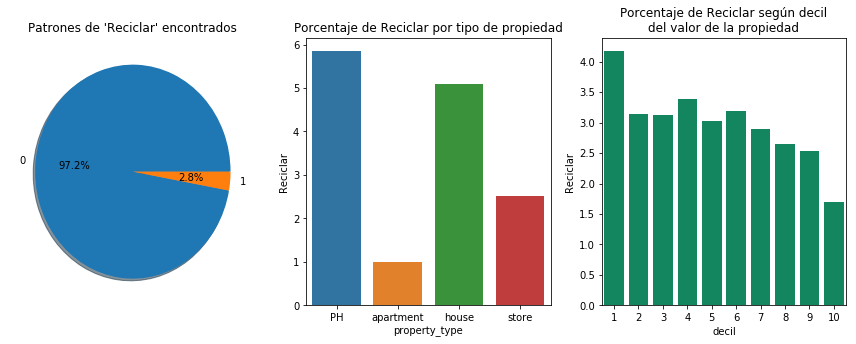

In [339]:
#Pattern
regexReciclar = re.compile("(?P<reciclar>reciclar|refaccionar|acondicionar|a terminar|para terminar)+")

data['Reciclar'] = 0
#Regex en la columna 'descripcion'
MatchsReciclar = data['description_lower'].apply(lambda x: x if x is np.NaN else regexReciclar.search(x))
maskReciclar_Match = MatchsReciclar.notnull()
data.loc[maskReciclar_Match, 'Reciclar'] = 1

#Regex en la columna 'title'
MatchsReciclar = data['title_lower'].apply(lambda x: x if x is np.NaN else regexReciclar.search(x))
maskReciclar_Match = MatchsReciclar.notnull()
data.loc[maskReciclar_Match, 'Reciclar'] = 1

chart_type('Reciclar')

---
<b><a id='section_3_10'>3.10. De Epoca</a>  </b>

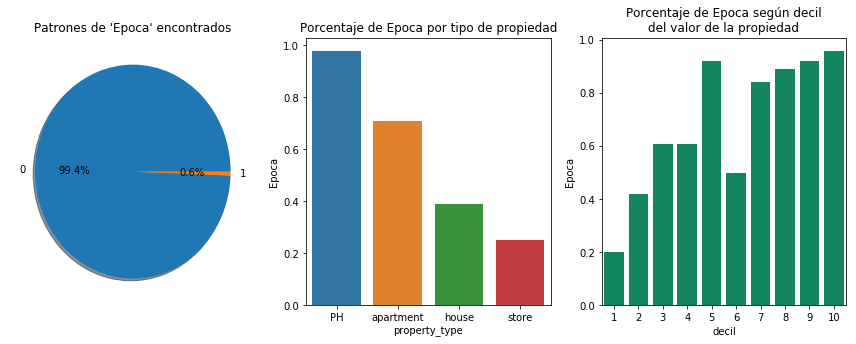

In [340]:
#Pattern
regexEpoca = re.compile("(?P<epoca>de [é|e]poca)+")

data['Epoca'] = 0
#Regex en la columna 'descripcion'
MatchsEpoca = data['description_lower'].apply(lambda x: x if x is np.NaN else regexEpoca.search(x))
maskEpoca_Match = MatchsEpoca.notnull()
data.loc[maskEpoca_Match, 'Epoca'] = 1

#Regex en la columna 'title'
MatchsEpoca = data['title_lower'].apply(lambda x: x if x is np.NaN else regexEpoca.search(x))
maskEpoca_Match = MatchsEpoca.notnull()
data.loc[maskEpoca_Match, 'Epoca'] = 1

chart_type('Epoca')

---
<b><a id='section_3_11'>3.11.Cantidad de Cocheras</a>  </b>

In [341]:
#Primer pattern
regexCantCoch = re.compile('(?P<numero>\d{1})\s?(cochera|garage|auto\s|automovil|vehiculo|\scoche\s|\scoches\s)')

data['cantcocheras'] = np.nan

#Regex en la columna 'descripcion'
MatchsCantCoch = data['description_lower'].apply(lambda x: x if x is np.NaN else regexCantCoch.search(x))
maskCantCoch_NullsAndMatch = data['cantcocheras'].isnull() & MatchsCantCoch.notnull()
data.loc[maskCantCoch_NullsAndMatch, 'cantcocheras'] = MatchsCantCoch[maskCantCoch_NullsAndMatch].apply(lambda x: float(x.group("numero")))

#Regex en la columna 'title'
MatchsCantCoch = data['title_lower'].apply(lambda x: x if x is np.NaN else regexCantCoch.search(x))
maskCantCoch_NullsAndMatch = data['cantcocheras'].isnull() & MatchsCantCoch.notnull()
data.loc[maskCantCoch_NullsAndMatch, 'cantcocheras'] = MatchsCantCoch[maskCantCoch_NullsAndMatch].apply(lambda x: float(x.group("numero")))

data['cantcocheras'].value_counts()


2.0    1475
1.0     865
0.0     321
3.0     307
4.0     205
8.0     132
5.0     120
7.0      73
6.0      66
9.0      34
Name: cantcocheras, dtype: int64

In [342]:
#Segundo pattern
regexCantCoch2 = re.compile('(?P<numeroPalabra>uno|un|dos|tres|cuatro|cinco|seis|siete|ocho|nueve)\s?(cochera|garage|auto\s|automovil|vehiculo|\scoche\s|\scoches\s)')

#Regex en la columna 'descripcion' usando la función MatchtoNumber
MatchsCantCoch2 = data['description_lower'].apply(lambda x: x if x is np.NaN else regexCantCoch2.search(x))
maskCantCoch2_NullsAndMatch = data['cantcocheras'].isnull() & MatchsCantCoch2.notnull()
data.loc[maskCantCoch2_NullsAndMatch, 'cantcocheras'] = MatchsCantCoch2[maskCantCoch2_NullsAndMatch].apply(MatchToNumber)

#Regex en la columna 'title' usando la función MatchtoNumber
MatchsCantCoch2 = data['title_lower'].apply(lambda x: x if x is np.NaN else regexAmbientes2.search(x))
maskCantCoch2_NullsAndMatch = data['cantcocheras'].isnull() & MatchsCantCoch2.notnull()
data.loc[maskCantCoch2_NullsAndMatch, 'cantcocheras'] = MatchsCantCoch2[maskCantCoch2_NullsAndMatch].apply(MatchToNumber)

data['cantcocheras'].value_counts()

2.0    3066
1.0    1822
3.0     806
4.0     332
0.0     321
5.0     174
8.0     147
7.0      74
6.0      74
9.0      34
Name: cantcocheras, dtype: int64

---
<b><a id='section_3_12'>3.12.Cantidad de baños</a>  </b>

In [343]:
# Primer Pattern
regexBanos = re.compile("(?P<numero>\d{1})\s?(baño|baños|banos|bano|banio|banios|baÃ±os|aÃ±os|toilette|toilettes|baÃ‘o)")

data['banos'] = np.nan

#Regex en la columna 'descripcion'
MatchsBanos = data['description_lower'].apply(lambda x: x if x is np.NaN else regexBanos.search(x))
maskBanos_NullsAndMatch = data['banos'].isnull() & MatchsBanos.notnull()
data.loc[maskBanos_NullsAndMatch, 'banos'] = MatchsBanos[maskBanos_NullsAndMatch].apply(lambda x: float(x.group("numero")))

#Regex en la columna 'title'
MatchsBanos = data['title_lower'].apply(lambda x: x if x is np.NaN else regexBanos.search(x))
maskBanos_NullsAndMatch = data['banos'].isnull() & MatchsBanos.notnull()
data.loc[maskBanos_NullsAndMatch, 'banos'] = MatchsBanos[maskBanos_NullsAndMatch].apply(lambda x: float(x.group("numero")))

data['banos'].value_counts()


2.0    5591
1.0    3696
3.0    1421
4.0     453
5.0     172
0.0     130
6.0      51
7.0      18
8.0      16
9.0       9
Name: banos, dtype: int64

In [344]:
# Segundo Pattern
regexBanos = re.compile("(?P<numeroPalabra>uno|un|dos|tres|cuatro|cinco|seis|siete|ocho|nueve)\s?(baño|baños|banos|bano|banio|banios|baÃ±os|aÃ±os|toilette|toilettes|baÃ‘o)")

#Regex en la columna 'descripcion'
MatchsBanos = data['description_lower'].apply(lambda x: x if x is np.NaN else regexBanos.search(x))
maskBanos_NullsAndMatch = data['banos'].isnull() & MatchsBanos.notnull()
data.loc[maskBanos_NullsAndMatch, 'banos'] = MatchsBanos[maskBanos_NullsAndMatch].apply(MatchToNumber)

#Regex en la columna 'title'
MatchsBanos = data['title_lower'].apply(lambda x: x if x is np.NaN else regexBanos.search(x))
maskBanos_NullsAndMatch = data['banos'].isnull() & MatchsBanos.notnull()
data.loc[maskBanos_NullsAndMatch, 'banos'] = MatchsBanos[maskBanos_NullsAndMatch].apply(MatchToNumber)

data['banos'].value_counts()

1.0    10178
2.0     8246
3.0     1667
4.0      502
5.0      183
0.0      130
6.0       56
7.0       18
8.0       16
9.0        9
Name: banos, dtype: int64

In [345]:
data['banos'] = data.banos.fillna(1)
data.banos.value_counts()

1.0    91327
2.0     8246
3.0     1667
4.0      502
5.0      183
0.0      130
6.0       56
7.0       18
8.0       16
9.0        9
Name: banos, dtype: int64

---
<b><a id='section_3_13'>3.13.Balcón</a>  </b>

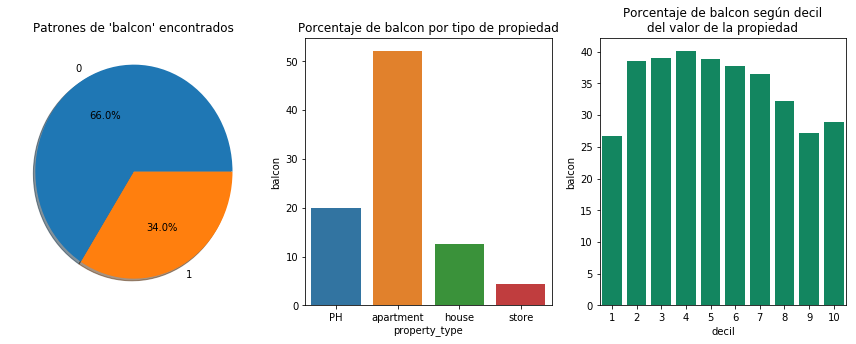

In [346]:
#Pattern
regexBalcon = re.compile("(?P<balcon>balcon|balcón|balcones)")

data['balcon'] = 0
#Regex en la columna 'descripcion'
MatchsBalcon = data['description_lower'].apply(lambda x: x if x is np.NaN else regexBalcon.search(x))
maskBalcon_Match = MatchsBalcon.notnull()
data.loc[maskBalcon_Match, 'balcon'] = 1

#Regex en la columna 'title'
MatchsBalcon = data['title_lower'].apply(lambda x: x if x is np.NaN else regexBalcon.search(x))
maskBalcon_Match = MatchsBalcon.notnull()
data.loc[maskBalcon_Match, 'balcon'] = 1

chart_type('balcon')

---
<b><a id='section_3_14'>3.14. A estrenar</a>  </b>

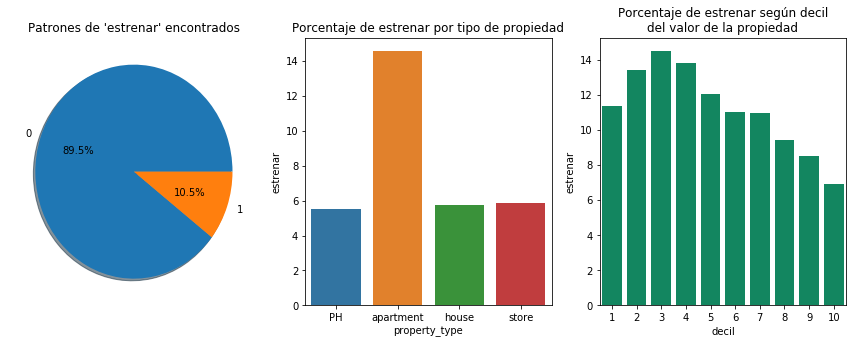

In [347]:
#Pattern
regexEstrenar = re.compile("(?P<Estrenar>(a estrenar)|(departamento nuevo))")

data['estrenar'] = 0
#Regex en la columna 'descripcion'
MatchsEstrenar = data['description_lower'].apply(lambda x: x if x is np.NaN else regexEstrenar.search(x))
maskEstrenar_Match = MatchsEstrenar.notnull()
data.loc[maskEstrenar_Match, 'estrenar'] = 1

#Regex en la columna 'title'
MatchsEstrenar = data['title_lower'].apply(lambda x: x if x is np.NaN else regexEstrenar.search(x))
maskEstrenar_Match = MatchsEstrenar.notnull()
data.loc[maskEstrenar_Match, 'estrenar'] = 1

chart_type('estrenar')

---
<b><a id='section_3_15'>3.15. Calefacción central / Losa radiante</a>  </b>

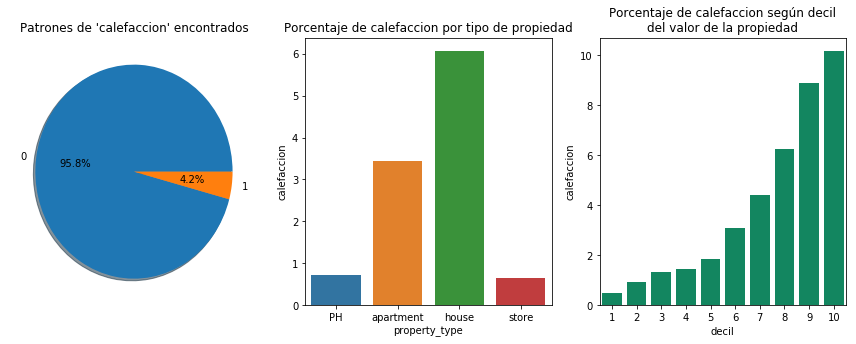

In [348]:
#Pattern
regexCalefaccion = re.compile("(?P<Calefaccion>(calefacciÃ³n por radiador)|(calefacciÃ³n central)|(calefaccion central)| \
(calefacción central)|(calefacciÃ³n por radiadores)|(calefaccion por losa radiante)|(calefacción por losa radiante))")

data['calefaccion'] = 0
#Regex en la columna 'descripcion'
MatchsCalefaccion = data['description_lower'].apply(lambda x: x if x is np.NaN else regexCalefaccion.search(x))
maskCalefaccion_Match = MatchsCalefaccion.notnull()
data.loc[maskCalefaccion_Match, 'calefaccion'] = 1

#Regex en la columna 'title'
MatchsCalefaccion = data['title_lower'].apply(lambda x: x if x is np.NaN else regexCalefaccion.search(x))
maskCalefaccion_Match = MatchsCalefaccion.notnull()
data.loc[maskCalefaccion_Match, 'calefaccion'] = 1

chart_type('calefaccion')

---
<b><a id='section_3_16'>3.16. Parque, Patio, Jardin</a>  </b>

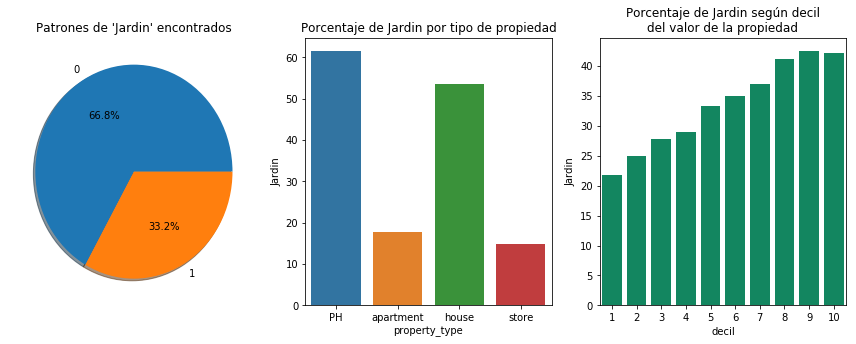

In [349]:
#Pattern
regexJardin = re.compile("(?P<parque>con parque|al parque|jard[i|í]n|patio)+")

data['Jardin'] = 0
#Regex en la columna 'descripcion'
MatchsJardin = data['description_lower'].apply(lambda x: x if x is np.NaN else regexJardin.search(x))
maskJardin_Match = MatchsJardin.notnull()
data.loc[maskJardin_Match, 'Jardin'] = 1

#Regex en la columna 'title'
MatchsJardin = data['title_lower'].apply(lambda x: x if x is np.NaN else regexJardin.search(x))
maskJardin_Match = MatchsJardin.notnull()
data.loc[maskJardin_Match, 'Jardin'] = 1

chart_type('Jardin')

---
---
<b><a id='section_4'><h4>4. Dataset final</h4></a></b>

Se construye un dataset con las variables que serán utilizadas en el modelo

In [350]:
data_final = data[['price_usd_per_m2_clean', 'surface_total_in_m2_clean','property_type','provincia','ciudad','departamento','barrio', 'rooms_clean', 'cantcocheras', 'banos',
                  'pileta','cochera','BarrioCerrado', 'Jacuzzi','Terraza','Quincho','Gimnasio', 'Seguridad', 'Reciclar','balcon', 'estrenar', 'calefaccion', 'Jardin',]]

data_final['surface_total_in_m2_clean']=data_final['surface_total_in_m2_clean'].round(1)

C:\ProgramData\Anaconda3\envs\dhds\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Se conserva únicamente las observaciones donde el <u>precio por metro cuadrado no es nulo</u>, ya que esta será la variable a estimar en el modelo

In [351]:
mask = data['price_usd_per_m2_clean'].notnull()
data_final = data_final.loc[mask,:]

In [352]:
data_describe_final = pd.DataFrame(round(data_final.isnull().sum() /data_final.shape[0],2), columns= ['Porcentaje de nulos'])
data_describe_final['type'] = data_final.dtypes
data_describe_final = data_describe_final[['type','Porcentaje de nulos']]
values= []
example=[]
for x in data_final:
    values.append(len(data_final[x].unique()))
    example.append(data_final[x].unique())
data_describe_final['Valores distintos'] = values
data_describe_final['Ejemplos'] = example
print("El dataset que se utilizará para realizar el modelo tiene",data_final.shape[0]," observaciones.")
data_describe_final

El dataset que se utilizará para realizar el modelo tiene 69147  observaciones.


,type,Porcentaje de nulos,Valores distintos,Ejemplos
price_usd_per_m2_clean,float64,0.00,4030,"[1474.0, 1467.0, 1136.0, 464.0, 1006.0, 1074.0..."
surface_total_in_m2_clean,float64,0.00,1533,"[296.5, 318.2, 303.8, 700.0, 397.8, 180.0, 150..."
property_type,object,0.00,4,"[house, apartment, PH, store]"
provincia,object,0.00,28,"[Bs.As. G.B.A. Zona Norte, Santa Fe, Bs.As. G...."
ciudad,object,0.03,409,"[Tigre, Pilar, Funes, La Plata, Escobar, Pinam..."
departamento,object,0.63,516,"[None, Tigre, Villa Rosa, Village Golf & Tenni..."
barrio,object,0.99,17,"[None, Barrio Los Lagos, Barrio Los Alisos, Ba..."
rooms_clean,float64,0.11,8,"[3.0, nan, 2.0, 4.0, 5.0, 1.0, 7.0, 6.0]"
cantcocheras,float64,0.94,11,"[nan, 1.0, 4.0, 2.0, 5.0, 0.0, 8.0, 3.0, 7.0, ..."
banos,float64,0.00,10,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 0.0, 8.0, 9.0, ..."


---
---
<b><a id='section_5'><h4>5. Construcción del modelo</h4></a></b>
<a href='#section_5_1'>5.1. Nuevas variables</a>    
<a href='#section_5_2'>5.2. Mínimos cuadrados ordinarios</a>  
<a href='#section_5_3'>5.3. Lasso</a>  
<a href='#section_5_4'>5.4. Ridge</a>   
<a href='#section_5_5'>5.5. Modelo CABA </a>  
<a href='#section_5_6'>5.6. Modelo Resto del pais </a>  

---
<b><a id='section_5_1'>5.1. Nuevas variables</a>  </b>

Generamos variables dummies para las variables categóricas vinculadas a tipo de propiedad y localidad.
La variable localidad fue considerada como la concatenación de las variables Ciudad, Departamento y Barrio

In [353]:
data_modelo  = data_final
data_modelo.shape

(69147, 23)

In [354]:
data_modelo[['ciudad','departamento','barrio']].head(5)

,ciudad,departamento,barrio
4,Tigre,None,None
5,Tigre,None,None
6,Tigre,None,None
7,Tigre,Tigre,None
14,Pilar,Villa Rosa,None


In [355]:
data_modelo['departamento'] = data_modelo['departamento'].fillna("_")
data_modelo['barrio'] = data_modelo['barrio'].fillna("_")
data_modelo['localidad'] = data_modelo['ciudad']+data_modelo['departamento']+data_modelo['barrio']
data_modelo[['localidad','ciudad','departamento','barrio']].head(5)

,localidad,ciudad,departamento,barrio
4,Tigre__,Tigre,_,_
5,Tigre__,Tigre,_,_
6,Tigre__,Tigre,_,_
7,TigreTigre_,Tigre,Tigre,_
14,PilarVilla Rosa_,Pilar,Villa Rosa,_


In [356]:
data_modelo = pd.get_dummies(data = data_modelo, columns = ["localidad"], drop_first = True)

In [357]:
data_modelo = pd.get_dummies(data = data_modelo, columns = [ "property_type"], drop_first = True)

In [358]:
data_modelo = pd.get_dummies(data = data_modelo, columns = [ "provincia"], drop_first = True)

Generamos nuevas variables para captar efecto sinergia

In [361]:
data_modelo.columns

Index(['price_usd_per_m2_clean', 'surface_total_in_m2_clean', 'ciudad',
       'departamento', 'barrio', 'rooms_clean', 'cantcocheras', 'banos',
       'pileta', 'cochera',
       ...
       'provincia_Salta', 'provincia_San Juan', 'provincia_San Luis',
       'provincia_Santa Cruz', 'provincia_Santa Fe',
       'provincia_Santiago Del Estero', 'provincia_Tierra Del Fuego',
       'provincia_Tucumán', 'house_mas_pileta', 'apartment_mas_cochera'],
      dtype='object', length=986)

In [363]:
data_modelo['property_type_PH']= data_modelo['property_type_house']+data_modelo['property_type_apartment']+data_modelo['property_type_store']
data_modelo['property_type_PH']=data_modelo['property_type_PH'].apply(lambda x: 1 if x==0 else 0 )

In [365]:
data_modelo['house_mas_pileta'] = data_modelo['property_type_house'] * data_modelo['pileta']
data_modelo['apartment_mas_cochera'] = data_modelo['property_type_apartment'] * data_modelo['cochera']
data_modelo['ph_mas_pileta'] = data_modelo['property_type_PH'] * data_modelo['pileta']
data_modelo['ph_mas_cochera'] = data_modelo['property_type_PH'] * data_modelo['cochera']
data_modelo['rooms_x_banos'] = data_modelo['rooms_clean'] * data_modelo['banos']

data_modelo=data_modelo.drop(['property_type_PH'],axis=1)

Generamos variables para captar efectos no lineales

In [366]:
data_modelo['surface_total_in_m2_clean_squared'] = data_modelo['surface_total_in_m2_clean']**2

Dataset para el modelo

In [367]:
data_modelo = data_modelo.drop(['ciudad','departamento','barrio', 'cantcocheras'], axis = 1)
data_modelo.dropna(inplace = True)

---
<b><a id='section_5_1'>5.2. Mínimos cuadrados ordinarios</a>  </b>

In [368]:
data_modelo = sm.add_constant(data_modelo)

In [369]:
data_modelo.shape

(61281, 987)

In [370]:
data_features = data_modelo.drop(["price_usd_per_m2_clean"], axis = 1)
target = data_modelo["price_usd_per_m2_clean"]

In [371]:
Xtrain , Xtest , ytrain , ytest = train_test_split(data_features,target, shuffle=True, stratify= pd.qcut(target,q=10), random_state=10, test_size=0.1)

Xtrain_original = Xtrain
Xtest_original = Xtest

model_sm = sm.OLS(ytrain,Xtrain).fit()

In [372]:
Xtrain.shape

(55152, 986)

In [373]:
model_sm.summary(title="MCO").tables[0]
#model_sm.summary()

Dep. Variable:,price_usd_per_m2_clean,R-squared:,0.714
Model:,OLS,Adj. R-squared:,0.710
Method:,Least Squares,F-statistic:,152.0
Date:,"Tue, 23 Jun 2020",Prob (F-statistic):,0.00
Time:,18:06:44,Log-Likelihood:,-4.1297e+05
No. Observations:,55152,AIC:,8.277e+05
Df Residuals:,54259,BIC:,8.357e+05
Df Model:,892,,
Covariance Type:,nonrobust,,


Generamos una función que permita eliminar las variables no significativas de manera iterativa hasta alcanzar un modelo en el cual todas las variables son significativas

In [374]:
list_alpha=[0.50,0.20,0.10,0.05,0.01]

variables_significativas = data_features.columns
variables_significativas_previo= variables_significativas.shape[0]
step=1

for alpha in list_alpha:
    variables_significativas_posterior=0
    while variables_significativas_posterior<variables_significativas_previo:
        Xtrain = Xtrain[variables_significativas]
        variables_significativas_previo= variables_significativas.shape[0]

        model_sm = sm.OLS(ytrain,Xtrain).fit()

        variables_significativas = pd.DataFrame(data = [x for x in model_sm.summary().tables[1].data[1:] if float(x[4]) < alpha],\
                                                columns = model_sm.summary().tables[1].data[0])['']
        
        variables_significativas_posterior=variables_significativas.shape[0]
        print(step, alpha,variables_significativas_previo,variables_significativas_posterior)
        step=step+1


1 0.5 986 664
2 0.5 664 635
3 0.5 635 628
4 0.5 628 622
5 0.5 622 620
6 0.5 620 618
7 0.5 618 613
8 0.5 613 613
9 0.2 613 498
10 0.2 498 496
11 0.2 496 496
12 0.1 496 423
13 0.1 423 404
14 0.1 404 399
15 0.1 399 399
16 0.05 399 352
17 0.05 352 345
18 0.05 345 345
19 0.01 345 272
20 0.01 272 269
21 0.01 269 267
22 0.01 267 267


In [375]:
print("Cantidad de variables iniciales:",data_features.shape[1])
print("Variables significativas  luego de la iteración:",variables_significativas.shape[0])

Cantidad de variables iniciales: 986
Variables significativas  luego de la iteración: 267


In [376]:
model_sm.summary(title="MCO solo con variables significativas").tables[0]
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     price_usd_per_m2_clean   R-squared:                       0.709
Model:                                OLS   Adj. R-squared:                  0.707
Method:                     Least Squares   F-statistic:                     502.2
Date:                    Tue, 23 Jun 2020   Prob (F-statistic):               0.00
Time:                            18:08:31   Log-Likelihood:            -4.1349e+05
No. Observations:                   55152   AIC:                         8.275e+05
Df Residuals:                       54885   BIC:                         8.299e+05
Df Model:                             266                                         
Covariance Type:                nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
const                                                          1300.3669     13.859     93.826      0.000    1273.202    1327.531
surface_total_in_m2_clean                                        -4.6314      0.063    -73.506      0.000      -4.755      -4.508
rooms_clean                                                      25.1906      2.503     10.065      0.000      20.285      30.096
banos                                                            42.9406      4.900      8.763      0.000      33.336      52.545
pileta                                                          126.3912      7.165     17.639      0.000     112.347     140.436
Jacuzzi                                                         187.1225     12.674     14.764      0.000     162.281     211.964
Quincho                                                          39.8164      5.877      6.775      0.000      28.297      51.335
Gimnasio                                                        112.0097      9.056     12.368      0.000      94.259     129.760
Seguridad                                                        56.2802      6.633      8.485      0.000      43.279      69.281
Reciclar                                                       -195.6626     11.721    -16.693      0.000    -218.636    -172.689
balcon                                                           67.6196      4.373     15.462      0.000      59.048      76.191
estrenar                                                         56.2353      5.864      9.590      0.000      44.742      67.728
calefaccion                                                     115.0179     10.024     11.474      0.000      95.371     134.665
Jardin                                                          -86.8321      4.489    -19.344      0.000     -95.630     -78.034
localidad_Almagro__                                              95.4585     19.351      4.933      0.000      57.530     133.387
localidad_Almirante BrownAdrogué_                               223.0658     24.084      9.262      0.000     175.862     270.270
localidad_Almirante BrownBurzaco_                              -310.7178     38.014     -8.174      0.000    -385.226    -236.210
localidad_Almirante BrownClaypole_                             -666.3266    109.662     -6.076      0.000    -881.266    -451.387
localidad_Almirante BrownDon Orione_                          -1199.1980    195.819     -6.124      0.000   -1583.004    -815.392
localidad_Almirante BrownGlew_                                 -240.9854     59.074     -4.079      0.000    -356.771    -125.200
localidad_Almirante BrownLongchamps_             

In [377]:
Xtest=Xtest[variables_significativas]

---
<b><a id='section_5_3'>5.3. Lasso</a>  </b>

Modelo Lasso con todas las variables

In [378]:
model_skl_LassoCV = linear_model.LassoCV(alphas=np.linspace(0.001,10, 100), cv=3, normalize=True)
model_skl_LassoCV.fit(Xtrain_original, ytrain)
print("Alpha óptimo:", model_skl_LassoCV.alpha_)
print("R2 Lasso de entrenamiento:",model_skl_LassoCV.score(Xtrain_original, ytrain).round(3))

Alpha óptimo: 0.001
R2 Lasso de entrenamiento: 0.714


In [379]:
betas = pd.DataFrame(data= model_skl_LassoCV.coef_ , index=Xtrain_original.columns, columns=['Betas'])

betas_0_mask = betas.Betas == 0
print("Variables igualadas a 0 por Lasso:", betas_0_mask.sum())
#pd.set_option('display.max_rows', 600)
#betas.loc[betas_0_mask,:]

Variables igualadas a 0 por Lasso: 153


Modelo Lasso con las variables detectadas como significativas

In [380]:
model_skl_LassoCV = linear_model.LassoCV(alphas=np.linspace(0.001,10, 100), cv=3, normalize=True)
model_skl_LassoCV.fit(Xtrain, ytrain)
print("Alpha óptimo:", model_skl_LassoCV.alpha_)
print("R2 Lasso de entrenamiento:",model_skl_LassoCV.score(Xtrain, ytrain).round(3))


Alpha óptimo: 0.001
R2 Lasso de entrenamiento: 0.709


In [381]:
betas = pd.DataFrame(data= model_skl_LassoCV.coef_ , index=Xtrain.columns, columns=['Betas'])

betas_0_mask = betas.Betas == 0
print("Variables igualadas a 0 por Lasso:", betas_0_mask.sum())
#betas.loc[betas_0_mask,:]

Variables igualadas a 0 por Lasso: 1


---
<b><a id='section_5_4'>5.4. Ridge</a>  </b>

WARNING: Los modelos Ridge tardan una eternidad en correr

Modelo Ridge con todas las variables

In [382]:
#model_skl_RidgeCV = linear_model.RidgeCV(alphas=np.linspace(0.001,10, 100), cv=3, normalize=True)
# model_skl_RidgeCV.fit(Xtrain_original, ytrain)
# print("Alpha óptimo:", model_skl_RidgeCV.alpha_)
# print("R2 Ridge de entrenamiento:",model_skl_RidgeCV.score(Xtrain_original, ytrain).round(2))

Modelo Ridge con las variables detectadas como significativas

In [383]:
# model_skl_RidgeCV = linear_model.RidgeCV(alphas=np.linspace(0.001,10, 100), cv=3, normalize=True)
# model_skl_RidgeCV.fit(Xtrain, ytrain)
# print("Alpha óptimo:", model_skl_RidgeCV.alpha_)
# print("R2 Ridge de entrenamiento:",model_skl_RidgeCV.score(Xtrain, ytrain).round(2))


---
<b><a id='section_5_5'>5.5. Predicción out of sample </a>  </b>

Se utilizara el modelo de MCO para predecir fuera de la muestra

In [384]:
ytest.shape, Xtest.shape

((6129,), (6129, 267))

In [385]:
prediction_sm = model_sm.predict(Xtest)
print ('R2 Statmodels OLS:', r2_score(ytest, prediction_sm).round(3))

R2 Statmodels OLS: 0.707


Text(0.5,0,'Y_test')

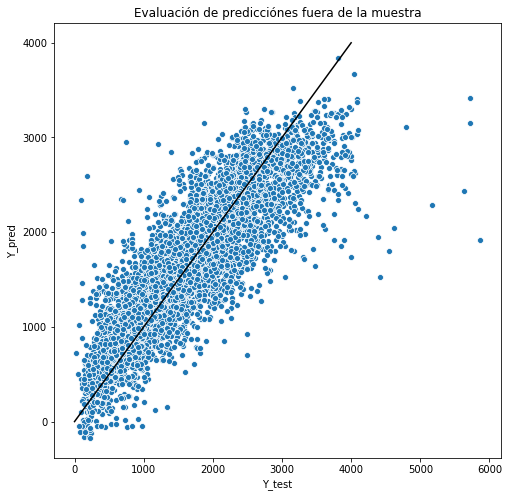

In [386]:
plt.figure(figsize=(8,8))
sns.scatterplot(ytest,prediction_sm)
sns.lineplot([0,4000],[0,4000],color='black')
plt.title("Evaluación de predicciónes fuera de la muestra")
plt.ylabel("Y_pred")
plt.xlabel("Y_test")

---
<b><a id='section_5_3'>5.3. Modelo CABA</a>  </b>

In [387]:
# dataCiudad = data_modelo

In [388]:
# dataCiudad = data[['property_type','provincia','ciudad','departamento','barrio',
#                    'price_aprox_usd_clean','surface_total_in_m2_clean','price_usd_per_m2_clean','rooms_clean',
#                   'pileta','cochera','BarrioCerrado', 'Jacuzzi','Terraza','Quincho','Gimnasio', 'Seguridad', 'Reciclar', 'cantcocheras', 'banos', 'balcon', 'estrenar', 'calefaccion', 'Jardin',]]

In [389]:
# dataCiudad = dataCiudad[dataCiudad.provincia == "Capital Federal"]
# dataCiudad = dataCiudad.drop(["barrio", "departamento", 'cantcocheras'], axis = 1)

In [390]:
# dataCiudad = pd.get_dummies(data = dataCiudad, columns = ["ciudad", "property_type"], drop_first = True)
# dataCiudad.head()

In [391]:
# dataCiudad.dropna(inplace = True)
# dataCiudadTarget = dataCiudad.price_usd_per_m2_clean

# dataCiudadFeatures = dataCiudad.drop(['price_aprox_usd_clean','price_usd_per_m2_clean','provincia'], axis = 1)
# dataCiudadFeatures["constant"] = 1

In [392]:
# dataCiudadFeatures.head()

In [393]:
# Xtrain , Xtest , ytrain , ytest = train_test_split(dataCiudadFeatures,dataCiudadTarget)
# model_sm = sm.OLS(ytrain,Xtrain).fit()
# model_reg_lasso = sm.OLS(ytrain,Xtrain).fit_regularized(method='elastic_net', alpha=0.02, L1_wt = 1)

In [394]:
# #model_sm.summary()
# print(Xtest.shape)
# print(ytest.shape)
# type(ytest)

In [395]:
# prediction_sm = model_sm.predict(Xtest)
# print ('R2 Statmodels OLS:', r2_score(ytest, prediction_sm).round(2))

---
<b><a id='section_5_4'>5.4. Modelo Resto del pais</a>  </b>

In [396]:
# dataNoCiudad = data[['property_type','provincia','ciudad','departamento','barrio',
#                    'price_aprox_usd_clean','surface_total_in_m2_clean','price_usd_per_m2_clean','rooms_clean',
#                   'pileta','cochera','BarrioCerrado', 'Jacuzzi','Terraza','Quincho','Gimnasio', 'Seguridad', 'Reciclar', 'cantcocheras', 'banos', 'balcon', 'estrenar', 'calefaccion', 'Jardin',]]

In [397]:
# dataNoCiudad = dataNoCiudad[dataNoCiudad.provincia != "Capital Federal"]
# dataNoCiudad = dataNoCiudad.drop(["barrio", "departamento", 'cantcocheras'], axis = 1)

# dataNoCiudad.head()

In [398]:
# dataNoCiudad = pd.get_dummies(data = dataNoCiudad, columns = ["ciudad", "property_type"], drop_first = True)
# dataNoCiudad.head()

In [399]:
# dataNoCiudad.dropna(inplace = True)
# dataNoCiudadTarget = dataNoCiudad.price_usd_per_m2_clean

# dataNoCiudadFeatures = dataNoCiudad.drop(['price_aprox_usd_clean','price_usd_per_m2_clean','provincia'], axis = 1)
# dataNoCiudadFeatures["constant"] = 1

In [400]:
# dataNoCiudadFeatures.head()

In [401]:
# XtrainN , XtestN , ytrainN , ytestN = train_test_split(dataNoCiudadFeatures,dataNoCiudadTarget)

# #Xtrain = sm.add_constant(Xtrain)
# model_smN = sm.OLS(ytrainN,XtrainN).fit()

# #model_reg_lasso = sm.OLS(ytrain,Xtrain).fit_regularized(method='elastic_net', alpha=0.02, L1_wt = 1)

In [402]:
# model_smN.summary()